* 만약 데이터사이언스, 머신러닝 또는 캐글에서 어떤 것을 해야하는지 잘 모르는 newbie 라면, 타이타닉을 하시는 게 가장 좋은 선택입니다.
* 타이나틱은 아시다시피, 사상 최대 해난사고로써, 1500여명의 희생자가 생겼습니다.
* 우리는 이 튜토리얼에서 타이타닉에 탑승한 사람들의 신상정보를 활용하여, 승선한 사람들의 생존여부를 예측하는 모델을 생성할 것입니다.
* 본 튜토리얼에서는 여러 시각화 도구(matplotlib, seaborn, plotly), 데이터 분석 도구(pandas, numpy), 머신 러닝 도구(sklearn)을 사용할 것입니다.
* 본 튜토리얼은 캐글에 있는 여러 커널들을 만들었습니다. 본 튜토리얼을 공부하신 뒤에, 캐글 타이타닉 컴퍼티션에 존재하는 여러 다른 커널들을 더 공부하시면 됩니다.
* 본 튜토리얼은 파이썬 문법에 어려움이 없으셔야 수월할 것입니다. 여기서 사용하는 라이브러리들을 써본 경험이 있으면 좋겠지만, 경험이 없다 하더라도 한 줄씩 천천히 적어나가시면 충분히 하실 수 있습니다.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn')
sns.set(font_scale=2.5) # 이 두줄은 본 필자가 항상 쓰는 방법입니다.
# matplotlib 의 기본 scheme 말고 seaborn scheme 을 세팅하고,
# 일일이 graph 의 font size 를 지정할 필요 없이 seaborn 의 font_scale 을 사용하면 편리합니다.
import missingno as msno # null data 확인용.

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# 새 창을 띄우지 않고 현재창에서 출력.
%matplotlib inline

앞으로 우리가 해야할 프로세스는 대략 아래와 같습니다.

1. 데이터셋 확인 - 대부분의캐글 데이터들은 잘 정제되어 있습니다. 하지만 가끔 null data가 존재합니다. 이를 확인하고, 향후 수정합니다.
2. 탐색적 데이터 분석(exploratory data analysis) - 여러 feature 들을 개별적으로 분석하고, feature 들 간의 상관관계를 확인합니다. 여러 시각화 툴을 사용하여 insight를 얻습니다.
3. feature engineering - 모델을 세우기에 앞서, 모델의 성능을 높일 수 있도록 feature 들을 engineering 합니다. one-hot encoding, class로 나누기, 구간으로 나누기, 텍스트 데이터 처리 등을 합니다.
4. model 만들기 - sklearn 을 사용해 모델을 만듭니다. 파이썬에서 머신러닝을 할 때는 sklearn 을 사용하면 수많은 알고리즘을 일관된 문법으로 사용할 수 있습니다. 물론 딥러닝을 위해 tensorflow, pytorch 등을 사용할 수 도 있습니다.
5. 모델 학습 및 예측 - trainset 을 가지고 모델을 학습시킨 후, testset 을 ㅏ지고 prediction 합니다.
6. 모델 평가 - 예측 성능이 원하는 수준인지 판단합니다. 풀려는 문제에 따라 모델을 평가하는 방식도 달라집니다. 학습된 모델이 어떤 것을 학습하였는 지 확인해봅니다.

# 1. Dataset 확인

* 파이썬에서 테이블화 된 데이터를 다루는 데 가장 최적화되어 있으며, 많이 쓰이는 라이브러리는 pandas 입니다.
* 우리는 pandas 를 사용하여 데이터셋의 간단한 통계적 분석 부터, 복잡한 처리들을 간단한 메소드를 사용하여 해낼 수 있습니다.
* 파이썬으로 데이터분석을 한다고 하면 반드시 능숙해져야 할 라이브러리이니, 여러 커널들을 공부하시면서 사용법에 익숫해지도록 반복 또 반복하시길 권장합니다.
* 캐글에서 데이터셋은 보통 train, testset 으로 나뉘어 있습니다.

In [2]:
# csv파일 데이터 가져오기
df_train = pd.read_csv('../input/titanic/train.csv')
df_test = pd.read_csv('../input/titanic/test.csv')

In [3]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


* 우리가 다루는 문제에서 feature는 Pclass, Age, SibSp, Parch, Fare 이며, 예측하려는 target label 은 Survived 입니다.

* pandas dataframe 에는 describe() 메소드가 있는 데, 이를 쓰면 각 feature 가 가진 통계치들을 반환해줍니다.

In [4]:
 df_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [5]:
df_test.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


* 테이블에서 보다시피, PassenserID 숫자와 다른, 그러니까 null data가 존재하는 열(feature)가 있는 것 같습니다.
* 이를 좀 더 보기 편하도록 그래프로 시각화해서 살펴봅시다.

# 1.1 Null data check

In [6]:
for col in df_train.columns:
    msg = 'column: {:>11}\t Percent of NaN value: {:.2f}%'.format(col, 100 * (df_train[col].isnull().sum() / df_train[col].shape[0]))
    print(msg)

column: PassengerId	 Percent of NaN value: 0.00%
column:    Survived	 Percent of NaN value: 0.00%
column:      Pclass	 Percent of NaN value: 0.00%
column:        Name	 Percent of NaN value: 0.00%
column:         Sex	 Percent of NaN value: 0.00%
column:         Age	 Percent of NaN value: 19.87%
column:       SibSp	 Percent of NaN value: 0.00%
column:       Parch	 Percent of NaN value: 0.00%
column:      Ticket	 Percent of NaN value: 0.00%
column:        Fare	 Percent of NaN value: 0.00%
column:       Cabin	 Percent of NaN value: 77.10%
column:    Embarked	 Percent of NaN value: 0.22%


In [7]:
for col in df_test.columns:
    msg = 'column: {:>11}\t Percent of NaN value: {:.2f}%'.format(col, 100 * (df_test[col].isnull().sum() / df_test[col].shape[0]))
    print(msg)

column: PassengerId	 Percent of NaN value: 0.00%
column:      Pclass	 Percent of NaN value: 0.00%
column:        Name	 Percent of NaN value: 0.00%
column:         Sex	 Percent of NaN value: 0.00%
column:         Age	 Percent of NaN value: 20.57%
column:       SibSp	 Percent of NaN value: 0.00%
column:       Parch	 Percent of NaN value: 0.00%
column:      Ticket	 Percent of NaN value: 0.00%
column:        Fare	 Percent of NaN value: 0.24%
column:       Cabin	 Percent of NaN value: 78.23%
column:    Embarked	 Percent of NaN value: 0.00%


* Train, Test set 에서 Age(둘다 약 20%), Cabin(둘다 약 80%), Embarked(Train만 0.22%) null data 존재하는 것을 볼 수 있습니다.
* MANO 라는 라이브러리를 사용하면 null data의 존재를 더 쉽게 볼 수 있습니다.

<AxesSubplot:>

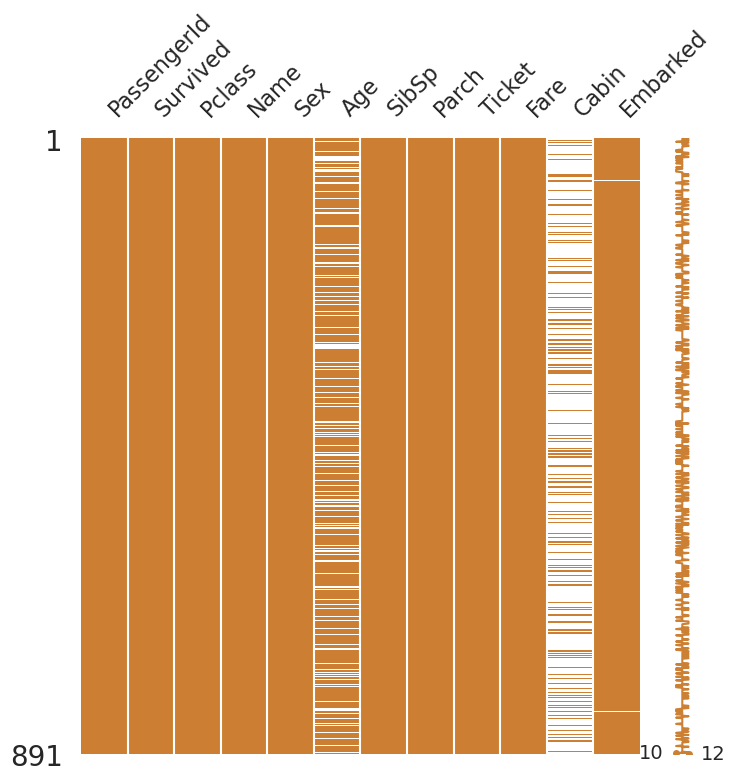

In [8]:
msno.matrix(df=df_train.iloc[:, :], figsize=(8, 8), color=(0.8, 0.5, 0.2))

<AxesSubplot:>

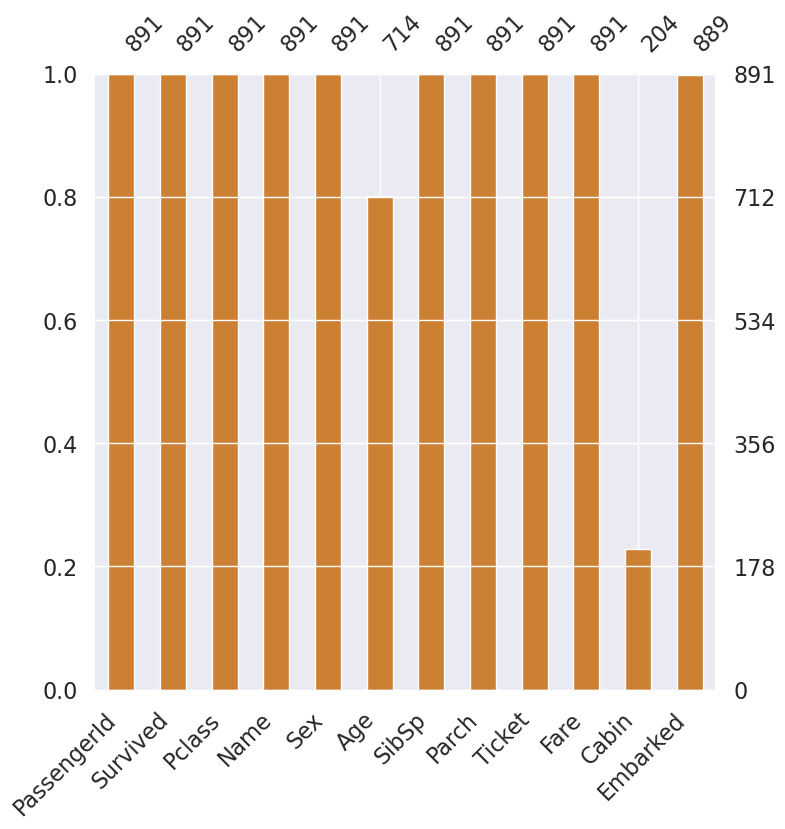

In [9]:
msno.bar(df=df_train.iloc[:, :], figsize=(8, 8), color=(0.8, 0.5, 0.2))

<AxesSubplot:>

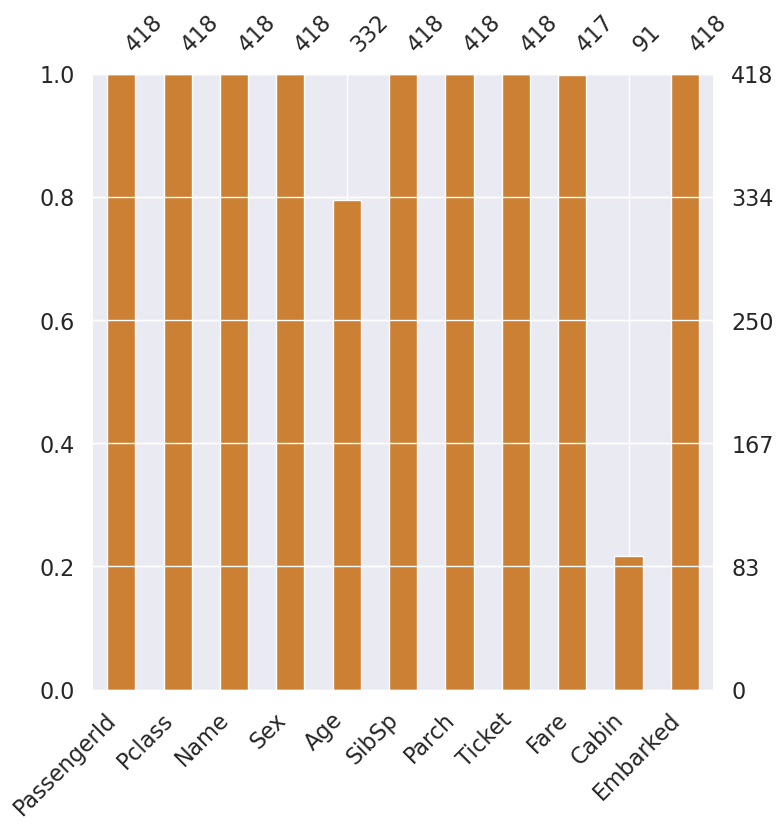

In [10]:
msno.bar(df=df_test.iloc[:, :], figsize=(8, 8), color=(0.8, 0.5, 0.2))

# 1.2 Target label 확인

* target label 이 어떤 distribution 을 가지고 있는 지 확인해봐야 합니다.
* 지금 같은 binary classification 문제의 경우에서, 1과 0의 분포가 어떠냐에 따라 모델의 평가 방법이 달라 질 수 있습니다.

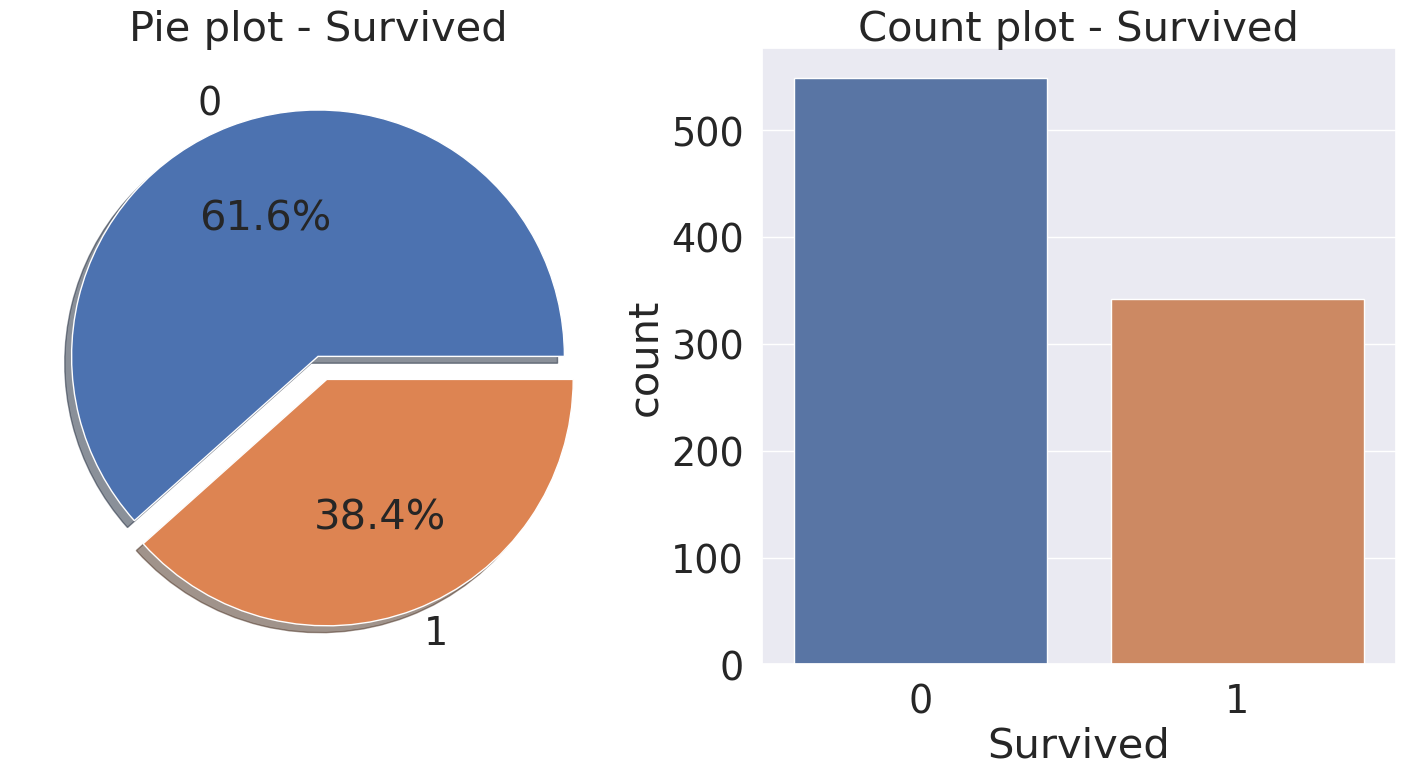

In [11]:
f, ax = plt.subplots(1, 2, figsize=(18, 8))

df_train['Survived'].value_counts().plot.pie(explode=[0, 0.1], autopct='%1.1f%%', ax=ax[0], shadow=True)
ax[0].set_title('Pie plot - Survived')
ax[0].set_ylabel('')
sns.countplot(data=df_train, x='Survived', ax=ax[1])
# sns.countplot('Survived', data=df_train, ax=ax[1]) 가 안되서 코드를 변경.
ax[1].set_title('Count plot - Survived')

plt.show()

* 안타깝게도 죽은 사람이 많습니다.
* 38.4 % 가 살아남았습니다.
* target label 의 분포가 제법 균일(balanced)합니다. 불균일한 경우, 예를 들어서 100중 1이 99, 0이 1개인 경우에는 만약 모델이 모든것을 1이라 해도 정확도가 98%가 나오게 됩니다. 0을 찾는 문제라면 이 모델은 원하는 결과를 줄 수 없게 됩니다. 지금 문제에서는 그렇지 않으니 계속 진행하겠습니다.

# 2. Exploratory data analysis

* 이제 본격적으로 데이터 분석을 해보겠습니다. 데이터는 매우 많습니다. 이 많은 데이터 안에 숨겨진 사실을 찾기 위해선 적절한 시각화가 필요합니다.
* 시각화 라이브러리는 matplotlib, seaborn, plotly 등이 있습니다. 특정 목적에 맞는 소스코드를 정리해두어 필요할 때마다 참고하면 편합니다.

## 2.1 Pclass 

* 먼저 Pclass 에 대해서 살펴보겠습니다. Pclass 는 ordinal, 서수형 데이터입니다. 카테고리이면서, 순서가 있는 데이터 타입입니다.
* 먼저 Pclass 에 따른 생존률의 차이를 살펴보겠습니다. 엑셀의 피벗 차트와 유사한 작업을 하게 되는데, pandas dataframe 에서는 groupby 를 사용하면 쉽게 할 수 있습니다. 또한 pivot 이라는 메소드도 있습니다.
* 'Pclass', 'Survived' 를 가져온 후, pclass 로 묶습니다. 그러고 나면 각 plcass 마다 0, 1 이 count 가 되는데, 이를 평균내면 각 pclass 별 생존률이 나옵니다.
* 아래와 같이 count() 를 하면, 각 class 에 몇명이 있는 지 확인할 수 있으며, sum() 을 하면, 216 명중 생존한(survived=1) 사람의 총합을 주게 됩니다.

In [12]:
# groupby 를 기준으로 카운트, as_index=True 인덱스로 사용.
df_train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=True).count()

,Survived
Pclass,
1,216
2,184
3,491


In [13]:
df_train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=True).sum()

,Survived
Pclass,
1,136
2,87
3,119


* pandas 의 crosstab 을 사용하면 좀 더 위 과정을 좀 더 수월하게 볼 수 있습니다.

In [14]:
# margins=기본값 False, True하면 All 생김.
pd.crosstab(df_train['Pclass'], df_train['Survived'], margins=True).style.background_gradient(cmap='summer_r')

Survived,0,1,All
Pclass,,,
1,80,136,216
2,97,87,184
3,372,119,491
All,549,342,891


* grouped 객체에 mean() 을 하게 되면, 각 클래스별 생존률을 얻을 수 있습니다. class 1 이면 아래와 같습니다.

80 / (80+136) ≈ 0.63

In [15]:
df_train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=True).mean()

,Survived
Pclass,
1,0.629630
2,0.472826
3,0.242363


<AxesSubplot:xlabel='Pclass'>

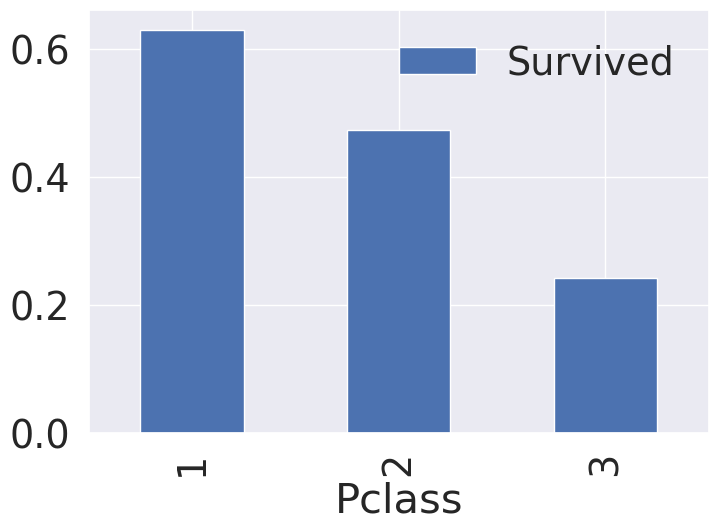

In [16]:
df_train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=True).mean().sort_values(by='Survived', ascending=False).plot.bar()

* 보다시피, Pclass 가 좋을 수록(1st) 생존률이 높은 것을 확인할 수 있습니다.
* 좀 더 보기 쉽게 그래프를 그려보겠습니다. seaborn 의 countplot 을 이용하면, 특정 label 에 따른 개수를 확인해볼 수 있습니다.

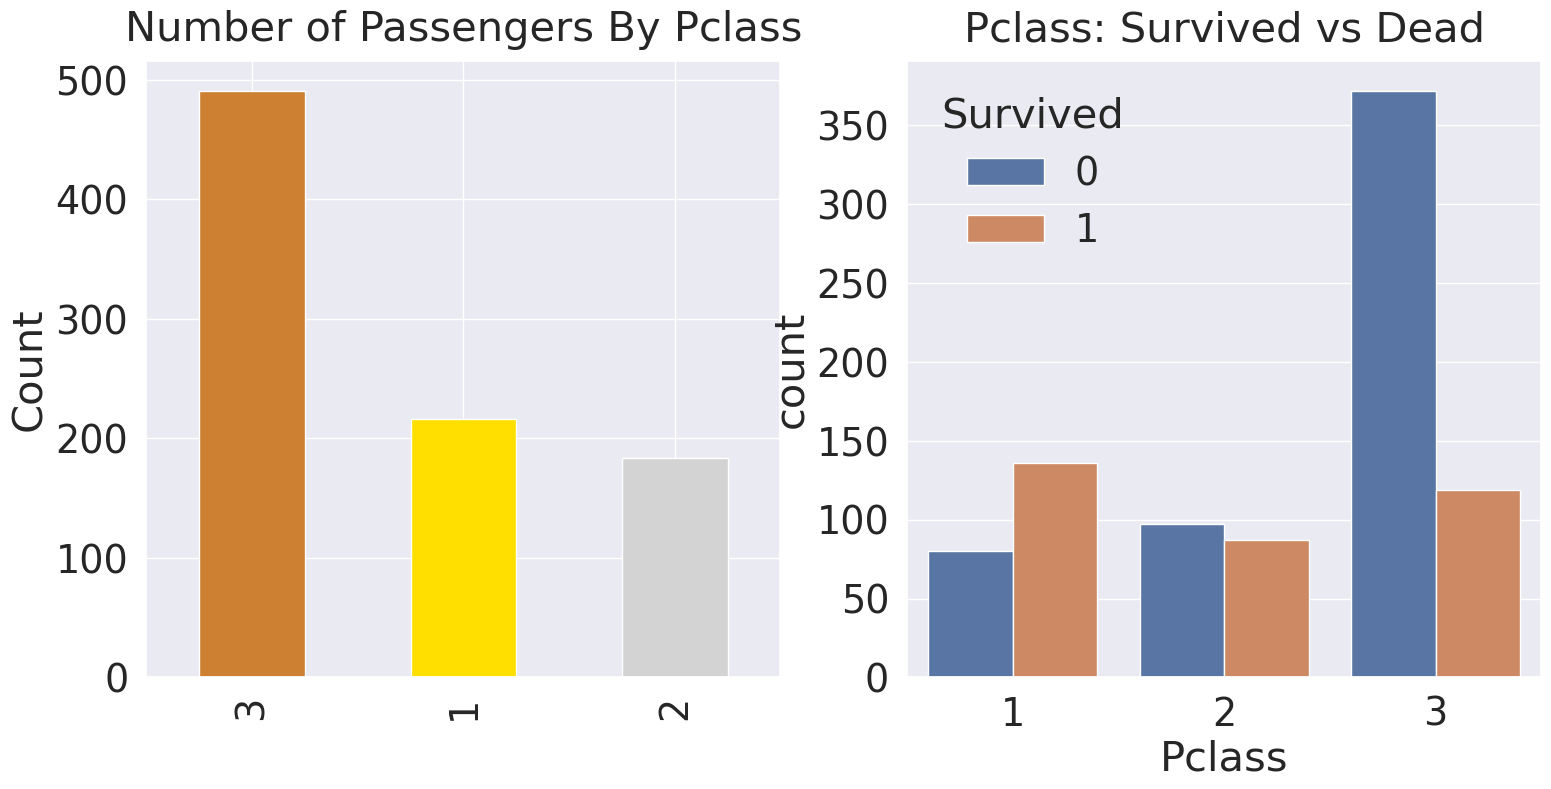

In [17]:
y_position = 1.02
f, ax = plt.subplots(1, 2, figsize=(18, 8))
df_train['Pclass'].value_counts().plot.bar(color=['#CD7F32', '#FFDF00', '#D3D3D3'], ax=ax[0])
ax[0].set_title('Number of Passengers By Pclass', y=y_position)
ax[0].set_ylabel('Count')
sns.countplot(data=df_train, x='Pclass', hue='Survived', ax=ax[1])
# sns.countplot('Pclass', hue='Survived', data=df_train, ax=ax[1])
ax[1].set_title('Pclass: Survived vs Dead', y=y_position)
plt.show()

* 클래스가 높을 수록, 생존 확률이 높은걸 확일할 수 있습니다. Pclass 1, 2, 3 순서대로 63%, 48%, 25% 입니다.
* 우리는 생존에 Pclass 가 큰 영향을 미친다고 생각해볼 수 있으며, 나중에 모델을 세울 때 이 feature 를 사용하는 것이 좋을 것이라 판단할 수 있습니다.

## 2.2 Sex

* 이번에는 성별로 생존률이 어떻게 달라지는 지 확인해보겠습니다.
* 마찬가지로 pandas groupby 와 seaborn countplot 을 사용해서 시각화해 봅시다.

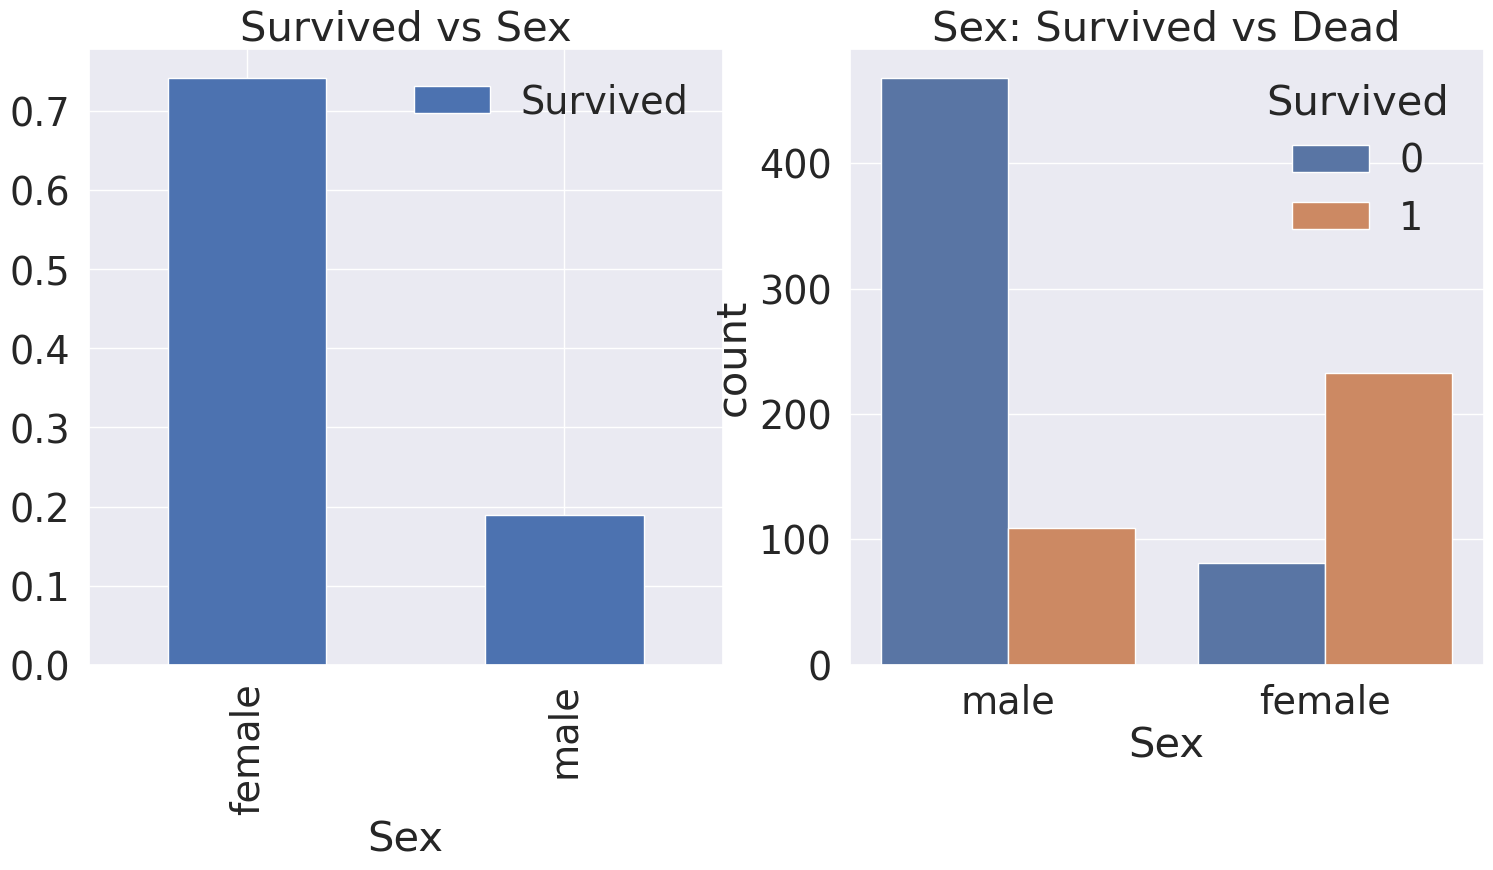

In [18]:
f, ax = plt.subplots(1, 2, figsize=(18, 8))
df_train[['Sex', 'Survived']].groupby(['Sex'], as_index=True).mean().plot.bar(ax=ax[0])
ax[0].set_title('Survived vs Sex')
sns.countplot(data=df_train, x='Sex', hue='Survived', ax=ax[1])
#sns.countplot('Sex', hue='Survived', data=df_train, ax=ax[1])
ax[1].set_title('Sex: Survived vs Dead')
plt.show()

* 보시다시피, 여자가 생존할 확률이 높습니다.

In [19]:
df_train[['Sex', 'Survived']].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [20]:
pd.crosstab(df_train['Sex'], df_train['Survived'], margins=True).style.background_gradient(cmap='summer_r')

Survived,0,1,All
Sex,,,
female,81,233,314
male,468,109,577
All,549,342,891


* Pclass 와 마찬가지로, Sex 도 예측 모델에 쓰일 중요한 feature 임을 알 수 있습니다.

## 2.3 Both Sex and Pclass

* 이번에는 Sex, Pclass 두가지에 관하여 생존이 어떻게 달라지는 지 확인해 봅시다
* seaborn 의 factorplot 을 이용하면, 손쉽게 3개의 차원으로 이루어진 그래프를 그릴 수 있습니다.

<AxesSubplot:xlabel='Pclass', ylabel='Survived'>

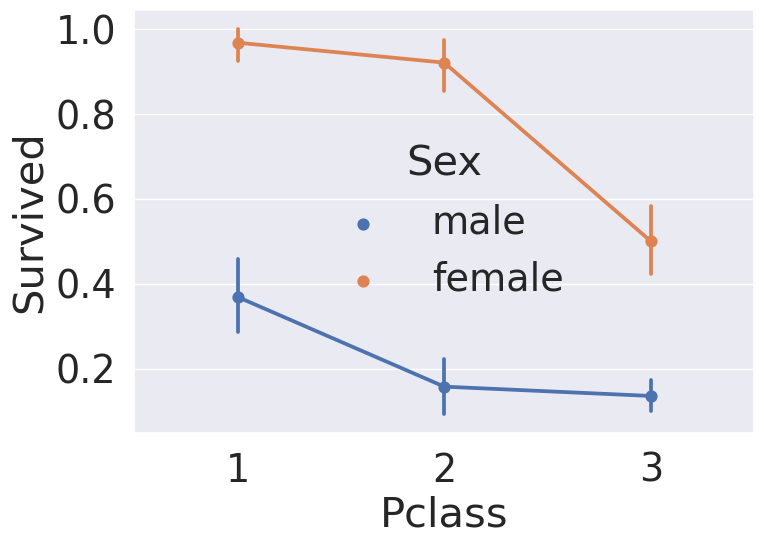

In [21]:
#sns.factorplot('Pclass', 'Survived', hue='Sex', data=df_train, size=6, aspect=1.5)
# sns 0.9.0 부터 factorplot이 사라진다고 하네요. 다른분은 0.9.0까지 된다고 하네요.
sns.pointplot(data=df_train, x='Pclass', y='Survived', hue='Sex')

* 모든 클래스에서 female 이 살 확률이 male 보다 높은 걸 알 수 있습니다.
* 또한 남자, 여자 상관없이 클래스가 높은 수록 살 확률 높습니다.
* 위 그래프는 hue 대신 column 으로 하면 아래와 같아집니다.

<AxesSubplot:xlabel='Sex', ylabel='Survived'>

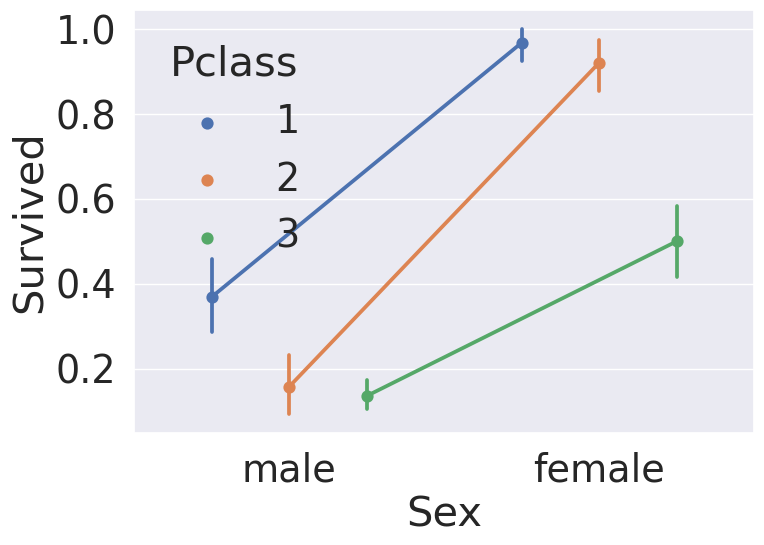

In [22]:
sns.pointplot(x='Sex', y='Survived', hue='Pclass', data=df_train, dodge=0.5)

## 2.4 Age

* 이번에는 Age feature 를 살펴봅시다.

In [23]:
print('제일 나이 많은 탑승객 : {:.1f} Years'.format(df_train['Age'].max()))
print('제일 어린 탑승객 : {:.1f} Years'.format(df_train['Age'].min()))
print('탑승객 평균 나이 : {:.1f} Years'.format(df_train['Age'].mean()))

제일 나이 많은 탑승객 : 80.0 Years
제일 어린 탑승객 : 0.4 Years
탑승객 평균 나이 : 29.7 Years


* 생존에 따른 Age의 histogram 을 그려보겠습니다.

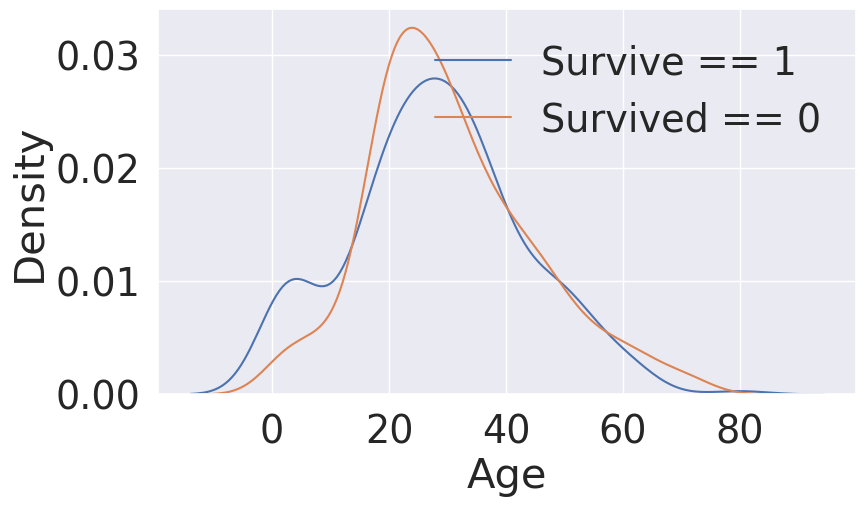

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(9, 5))
sns.kdeplot(df_train[df_train['Survived'] == 1]['Age'], ax=ax)
sns.kdeplot(df_train[df_train['Survived'] == 0]['Age'], ax=ax)
plt.legend(['Survive == 1', 'Survived == 0'])
plt.show()

* 보다시피, 생존자 중 나이가 어린 경우가 많음을 볼 수 있습니다.

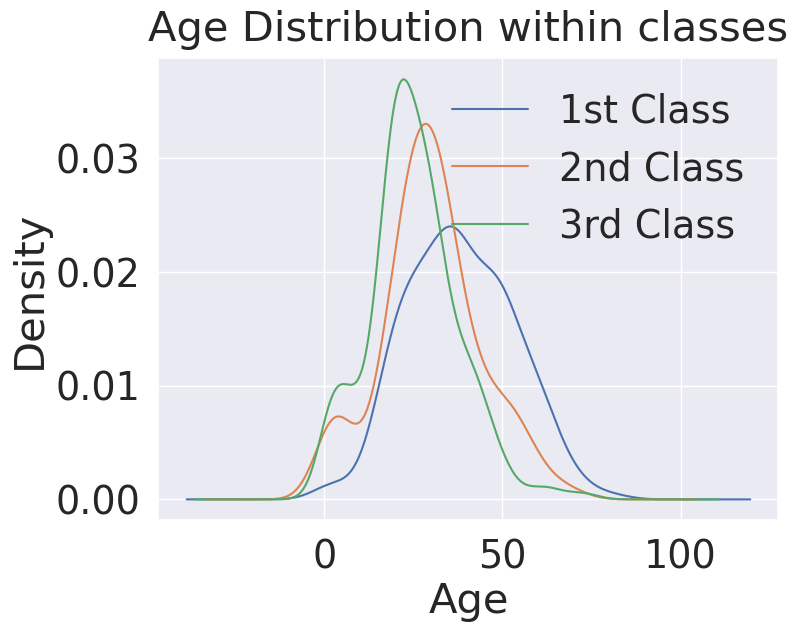

In [25]:
# Age distribution withing classes
plt.figure(figsize=(8, 6))
df_train['Age'][df_train['Pclass'] == 1].plot(kind='kde')
df_train['Age'][df_train['Pclass'] == 2].plot(kind='kde')
df_train['Age'][df_train['Pclass'] == 3].plot(kind='kde')

plt.xlabel('Age')
plt.title('Age Distribution within classes', y=1.02)
plt.legend(['1st Class', '2nd Class', '3rd Class'])
plt.show()

* Class 가 높을 수록 나이 많은 사람의 비중이 커짐
* 나이대가 변하면서 생존률이 어떻게 되는 지 보려고 합니다.
* 나이범위를 점점 넓혀가며, 생존률이 어떻게 되는지 한번 봅시다

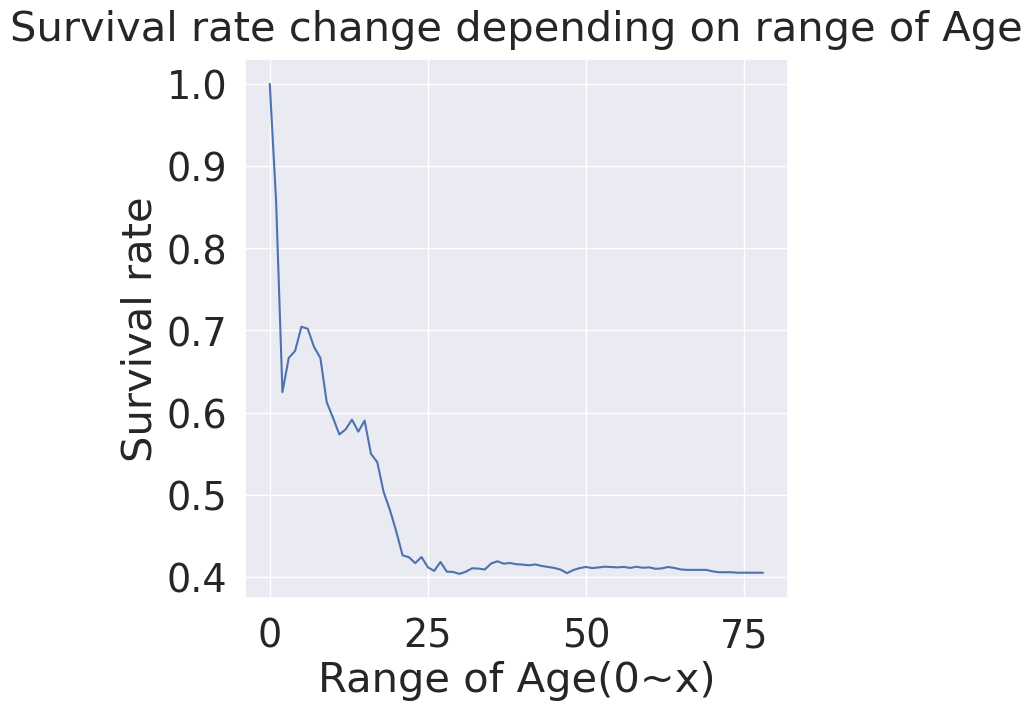

In [26]:
cummulate_survival_ratio = []
for i in range(1, 80):
    cummulate_survival_ratio.append(df_train[df_train['Age'] < i]['Survived'].sum() / len(df_train[df_train['Age'] < i]['Survived']))

plt.figure(figsize=(7, 7))
plt.plot(cummulate_survival_ratio)
plt.title('Survival rate change depending on range of Age', y=1.02)
plt.ylabel('Survival rate')
plt.xlabel('Range of Age(0~x)')
plt.show()

* 보시다시피, 나이가 어릴 수록 생존률이 확실히 높은것을 확인할 수 있습니다.
* 우리는 이 나이가 중요한 feature 로 쓰일 수 있음을 확인했습니다.

# 2.5 Pclass, Sex, Age

* 지금까지 본, Sex, Pclass, Age, Survived 모두에 대해서 보고싶습니다. 이를 쉽게 그려주는 것이 seaborn 의 violinplot 입니다
* x 축은 우리가 나눠서 보고싶어하는 case(여기선 Pclass, Sex) 를 나타내고, y 축은 보고 싶어하는 distribution(Age) 입니다.
* 한번 그려보겠습니다.

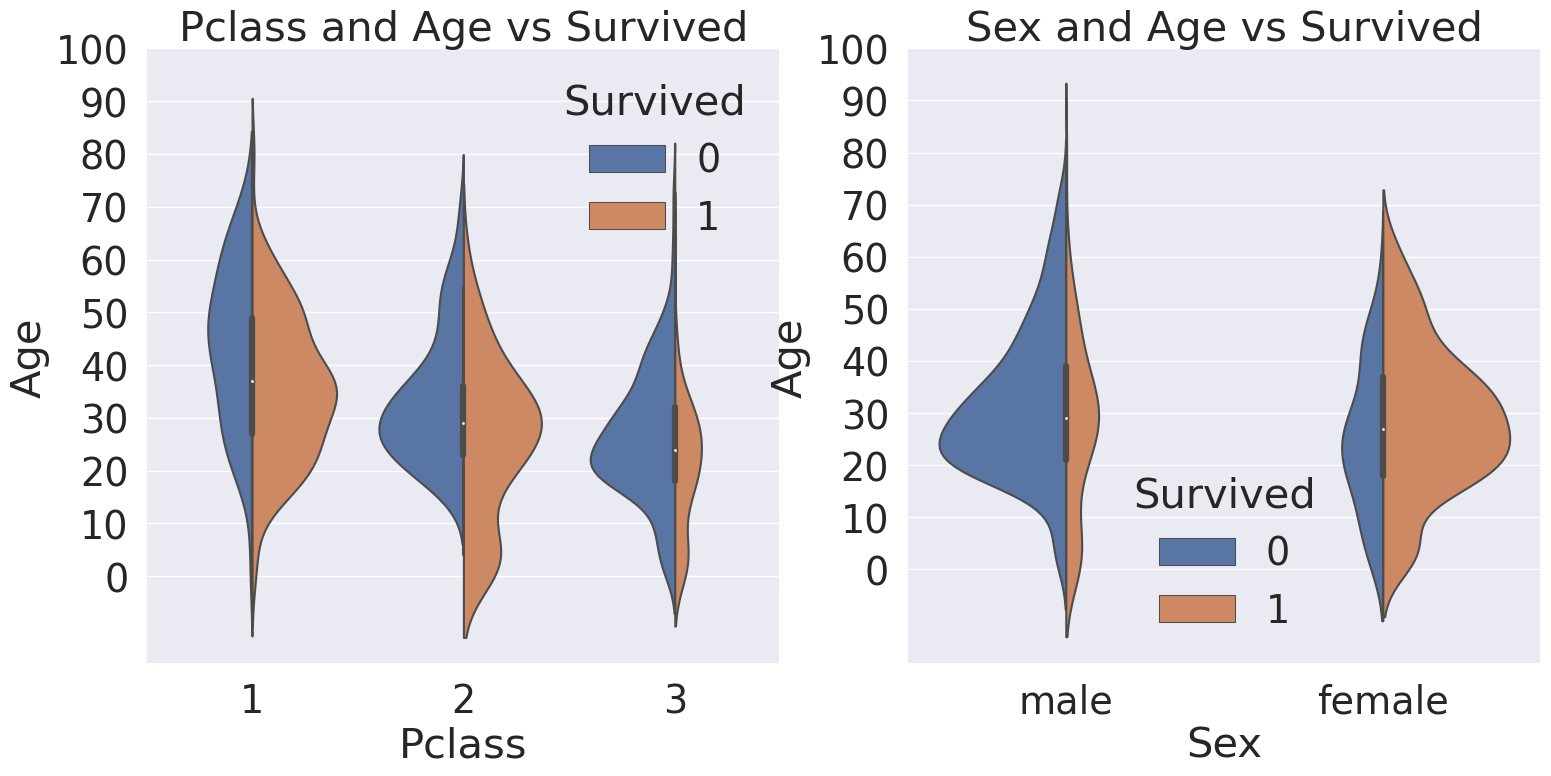

In [27]:
f, ax = plt.subplots(1, 2, figsize=(18, 8))
sns.violinplot(x='Pclass', y='Age', hue='Survived', data=df_train, scale='count', split=True, ax=ax[0])
ax[0].set_title('Pclass and Age vs Survived')
ax[0].set_yticks(range(0, 110, 10))
sns.violinplot(x='Sex', y='Age', hue='Survived', data=df_train, scale='count', split=True, ax=ax[1])
ax[1].set_title('Sex and Age vs Survived')
ax[1].set_yticks(range(0, 110, 10))
plt.show()

* 왼쪽 그림은 Pclass 별로 Age의 distribution 이 어떻게 다른지, 거기에 생존여부에 따라 구분한 그래프입니다.
* 오른쪽 그림도 마찬가지 Sex, 생존에 따른 distribution 이 어떻게 다른지 보여주는 그래프입니다.
* 생존만 봤을 때, 모든 클래스에서 나이가 어릴 수록 생존을 많이 한것을 볼 수 있습니다.
* 오른쪽 그림에서 보면, 명확히 여자가 생존을 많이 한것을 볼 수 있습니다.
* 여성과 아이를 먼저 챙긴 것을 볼 수 있습니다.

# 2.6 Embarked

* Embarked 는 탑승한 항구를 나타냅니다.
* 위에서 해왔던 것과 비슷하게 탑승한 곳에 따른 생존률을 보겠습니다.

<AxesSubplot:xlabel='Embarked'>

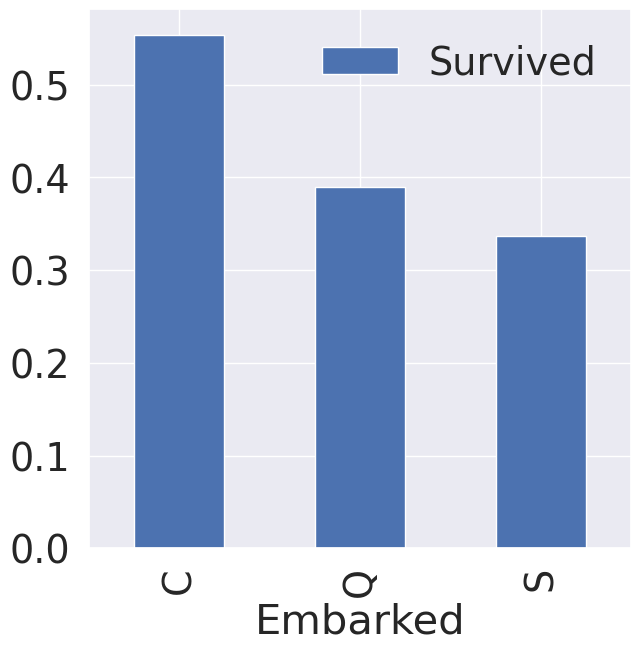

In [28]:
f, ax = plt.subplots(1, 1, figsize=(7, 7))
df_train[['Embarked', 'Survived']].groupby(['Embarked'], as_index=True).mean().sort_values(by='Survived', ascending=False).plot.bar(ax=ax)

* 보시다시피, 조금의 차이는 있지만 생존률은 좀 비슷한 거 같습니다. 그래도 C가 제일 높군요
* 모델에 얼마나 큰 영햘을 미칠지는 모르겠지만, 그래도 사용하겠습니다.
* 사실, 모델을 만들고 나면 우리가 사용한 feature 들이 얼마나 중요한 역할을 했는지 확인해볼 수 있습니다. 이는 추후에 모델을 만들고 난 다음에 살펴볼 것입니다.
* 다른 feature 로 split 하여 한번 살펴보겠습니다.

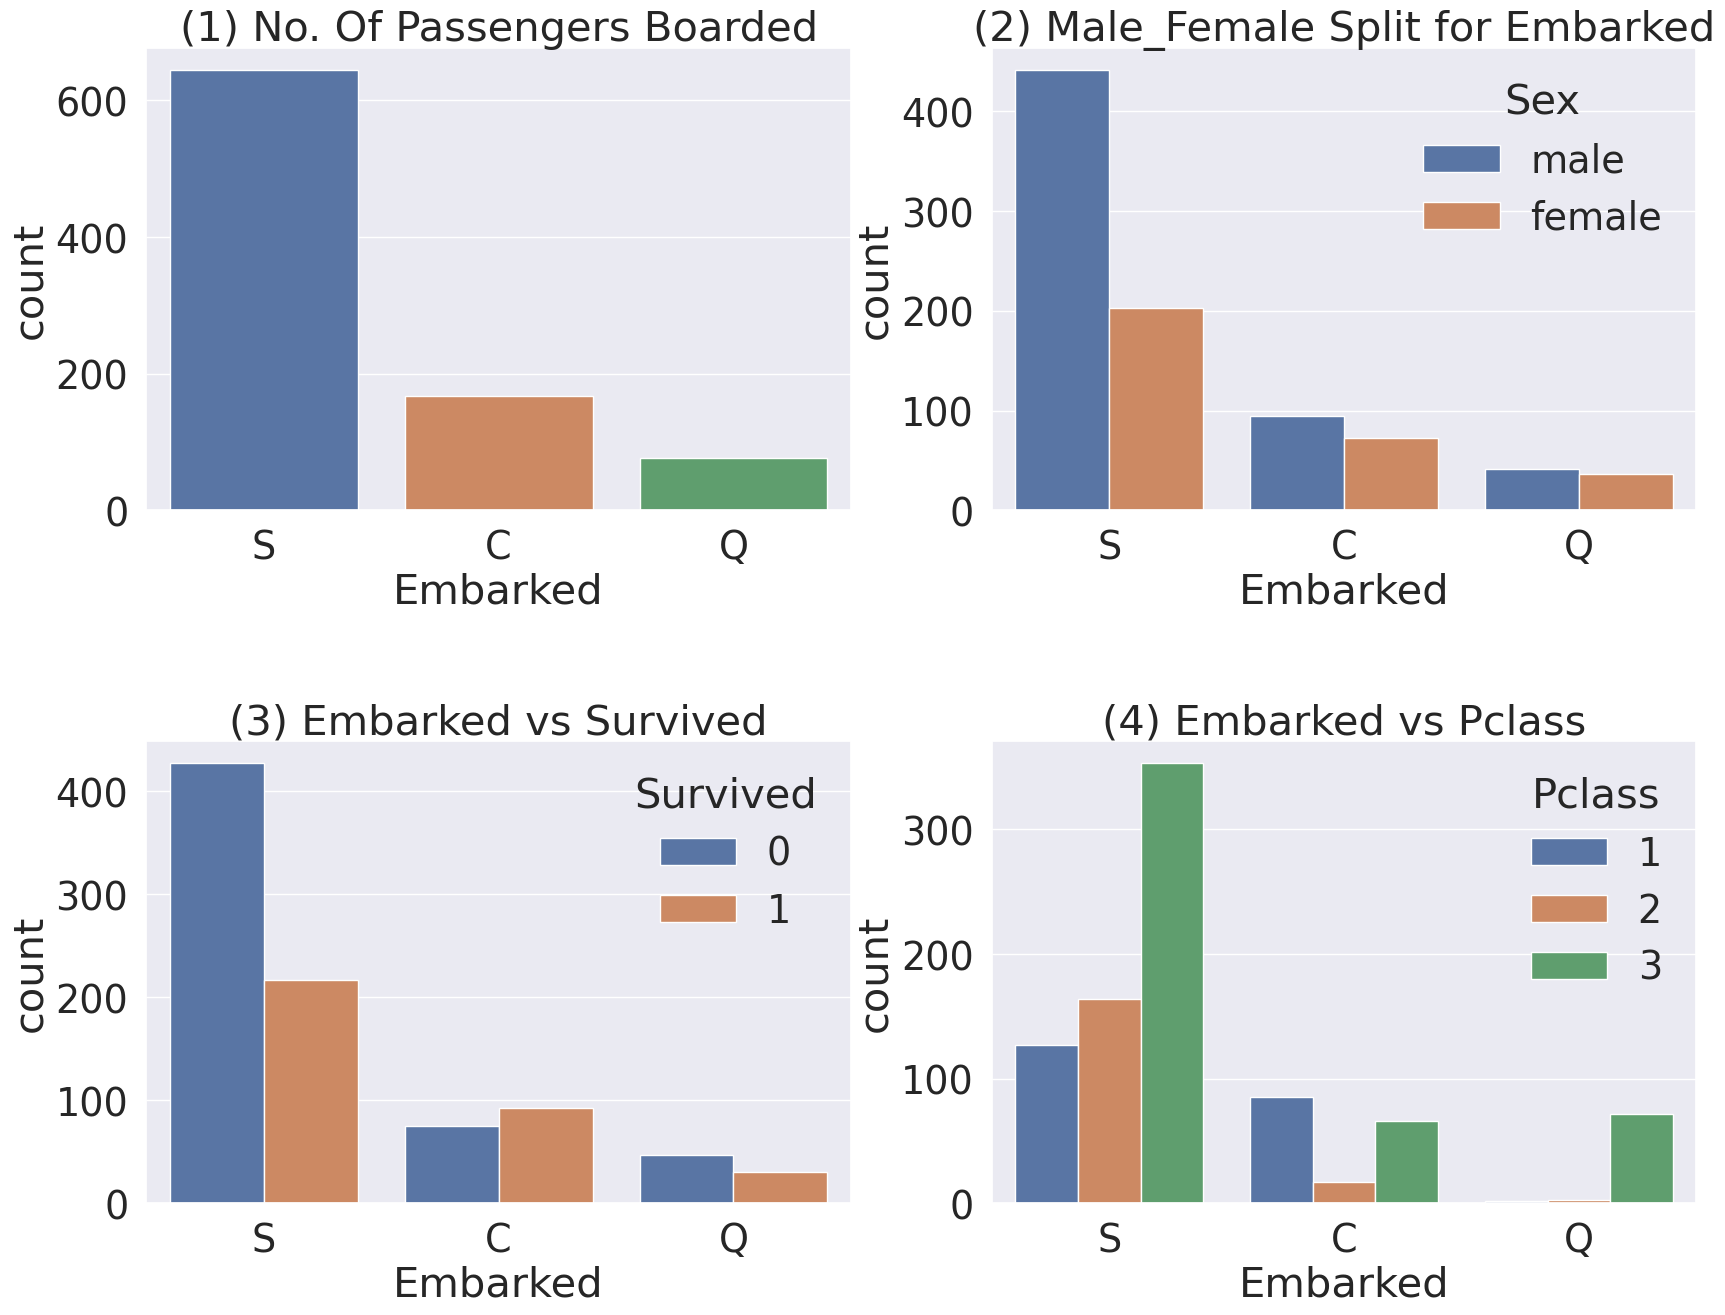

In [29]:
f, ax = plt.subplots(2, 2, figsize=(20, 15))
sns.countplot(x='Embarked', data=df_train, ax=ax[0,0])
ax[0,0].set_title('(1) No. Of Passengers Boarded')
sns.countplot(x='Embarked', hue='Sex', data=df_train, ax=ax[0,1])
ax[0,1].set_title('(2) Male_Female Split for Embarked')
sns.countplot(x='Embarked', hue='Survived', data=df_train, ax=ax[1,0])
ax[1,0].set_title('(3) Embarked vs Survived')
sns.countplot(x='Embarked', hue='Pclass', data=df_train, ax=ax[1,1])
ax[1,1].set_title('(4) Embarked vs Pclass')
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

* Figure(1) - 전체적으로 봤을 때, S 에서 가장 많은 사람이 탑승했습니다.
* Figure(2) - C와 Q 는 남녀의 비율이 비슷하고, S는 남자가 더 많습니다.
* Figure(3) - 생존확률이 S 경우 많이 낮은 걸 볼 수 있습니다. (이전 그래프에서 봤었습니다)
* Figure(4) - Class 로 split 해서 보니, C가 생존확률이 높은건 클래스가 높은 사람이 많이 타서 그렇습니다. S는 class 가 많아서 생존확률이 낮게 나옵니다.

# 2.7 Family - SibSp(형제 자매) + Parch(부모, 자녀)

* SibSp와 Parch를 합ㅎ면 Family 가 될 것입니다. Family 로 합쳐서 분석해봅시다.

In [30]:
df_train['FamilySize'] = df_train['SibSp'] + df_train['Parch'] + 1
# 자신을 포함해야하니 1을 더합니다.
df_test['FamilySize'] = df_test['SibSp'] + df_test['Parch'] + 1
# 자신을 포함해야하니 1을 더합니다.

In [31]:
print('Maximum size of Family: ', df_train['FamilySize'].max())
print('Minimun size of Family: ', df_train['FamilySize'].min())

Maximum size of Family:  11
Minimun size of Family:  1


* FamilySize 와 생존의 관계를 한번 살펴봅시다.

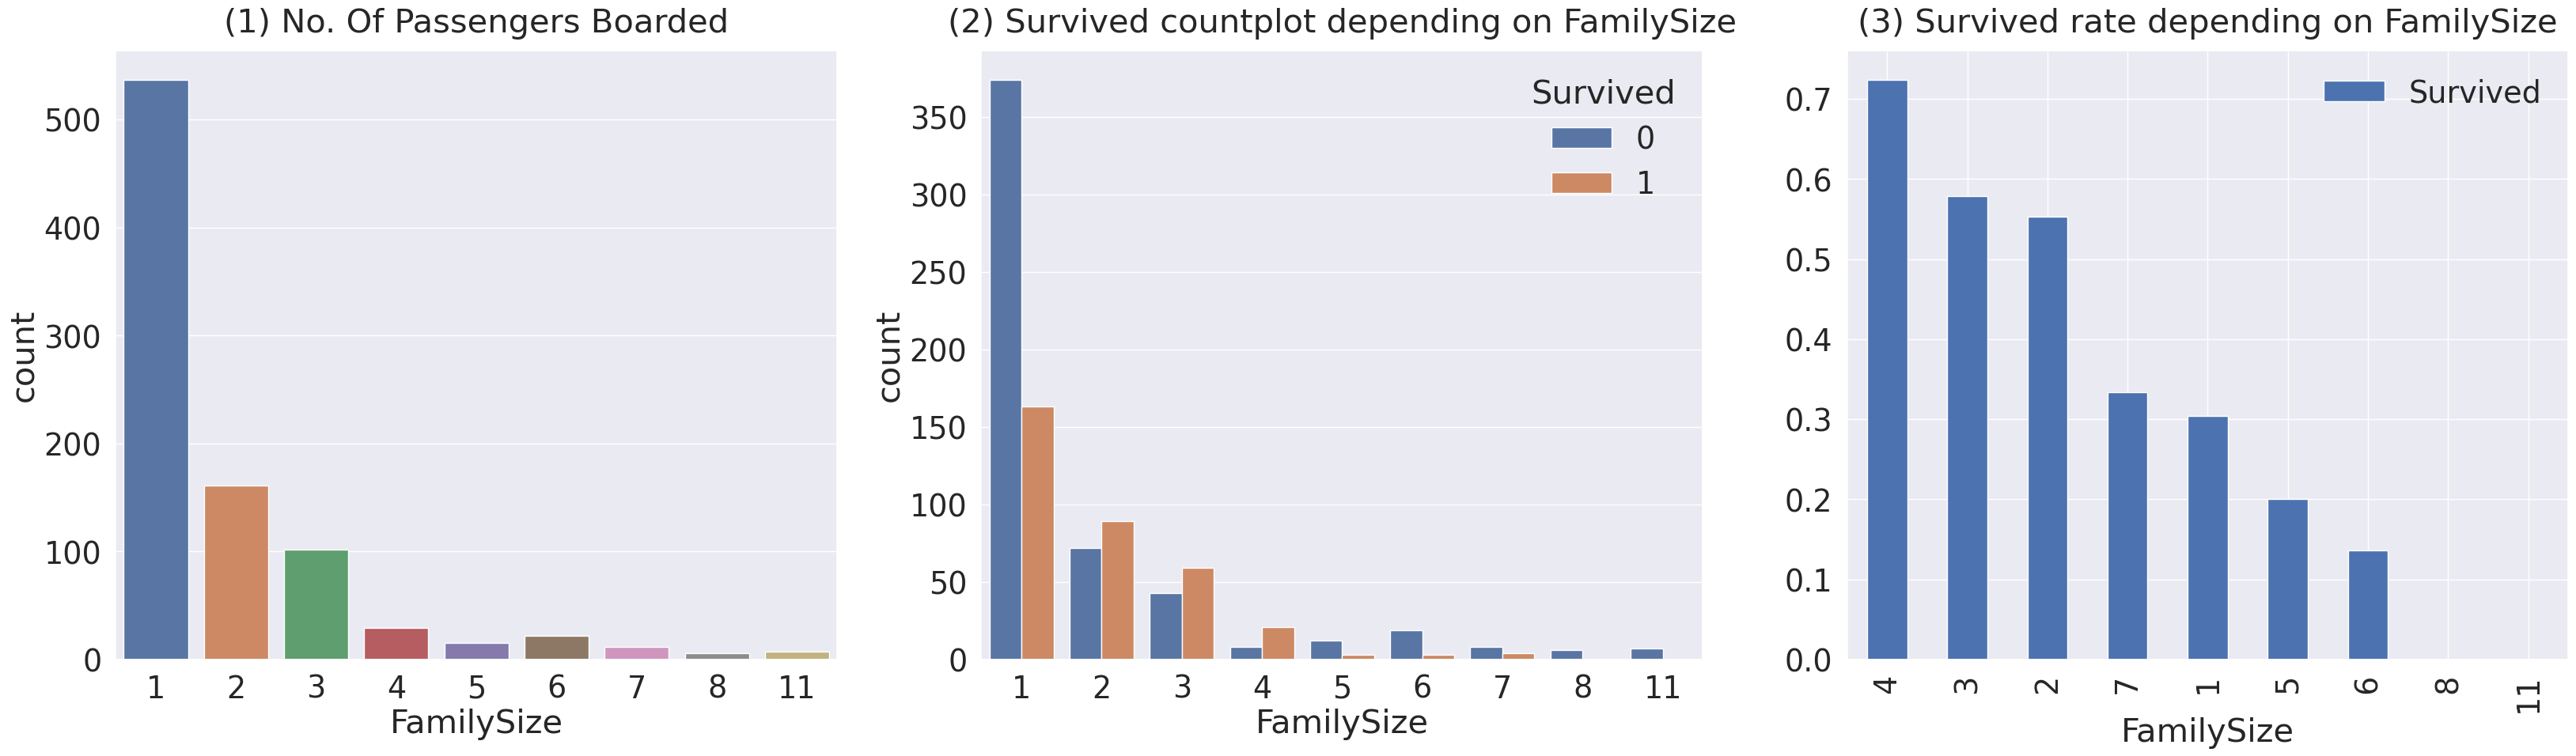

In [32]:
f, ax = plt.subplots(1, 3, figsize=(40, 10))
sns.countplot(x='FamilySize', data=df_train, ax=ax[0])
ax[0].set_title('(1) No. Of Passengers Boarded', y=1.02)

sns.countplot(x='FamilySize', hue='Survived', data=df_train, ax=ax[1])
ax[1].set_title('(2) Survived countplot depending on FamilySize', y=1.02)

df_train[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=True).mean().sort_values(by='Survived', ascending=False).plot.bar(ax=ax[2])
ax[2].set_title('(3) Survived rate depending on FamilySize', y=1.02)

plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

In [33]:
df_train['SibSp'].max() # 비속

8

In [34]:
df_train['Parch'].max() # 존속

6

* Figure (1) - 가족크기가 1~11까지 있음을 볼 수 있습니다. 대부분 1명이고 그 다음으로 2, 3, 4명입니다.
* Figure (2), (3) - 가족 크기에 따른 생존비교입니다. 가족이 4명인 경우가 가장 생존확률이 높습니다. 가족수가 많아질수록, (5, 6, 7, 8, 11) 생존확률이 낮아지네요. 가족수가 너무 작아도(1), 너무 커도(5, 6, 8, 11) 생존 확률이 작네요. 3~4명 선에서 생존확률이 높은 걸 확인할 수 있습니다.

# 2.8 Fare

* Fare 는 탑승요금이며, contious feature 입니다. 한번 histogram 을 그려보겠습니다.

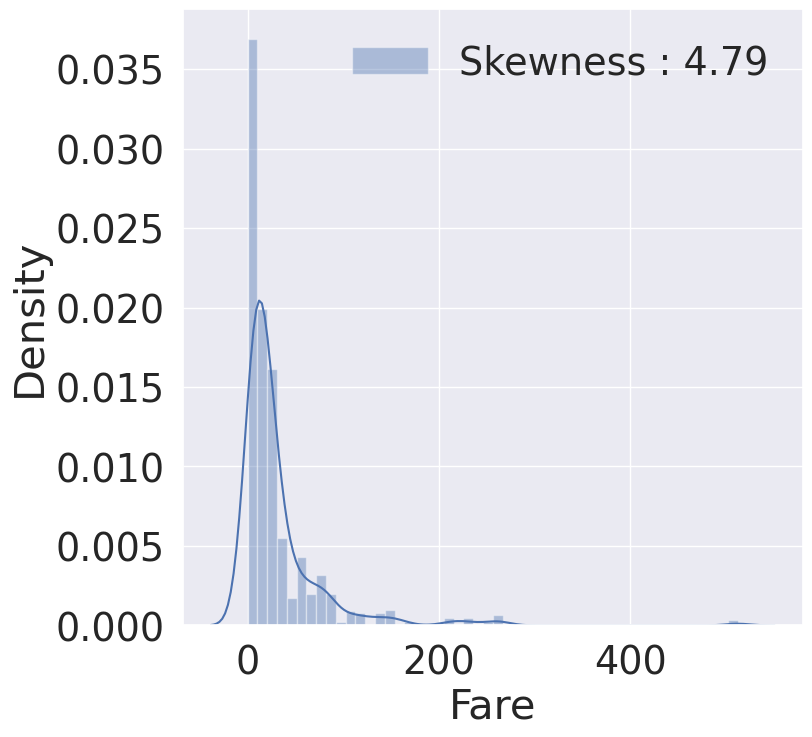

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
g = sns.distplot(df_train['Fare'], color='b', label='Skewness : {:.2f}'.format(df_train['Fare'].skew()), ax=ax)
g = g.legend(loc='best')

* 보시다시피, distribution이 매우 비대칭인 것을 알 수 있습니다.(highskewness). 만약 이대로 모델에 넣어준다면 자칫 모델이 잘못 학습할 수도 있습니다. 몇개 없는 outlier 에 대해서 너무 민감하게 반응한다면, 실제 예측 시에 좋지 못한 결과를 부를 수 있습니다.
* outlier의 영향을 줄이기 위해 Fare 에 log 를 취하겠습니다.
* 여기서 우리는 pandas 의 유용한 기능을 사용할 겁니다. dataFrame 의 특정 columns 에 공통된 작업(함수)를 적용하고 싶으면 아래의 map, 또는 apply 를 사용하면 매우 손쉽게 적용할 수 있습니다.
* 우리가 지금 원하는 것은 Fare columns 의 데이터 모두를 log 값 취하는 것인데, 파이썬의 간단한 lambda 함수를 이용해 간단한 로그를 적용하는 함수를 map 에 인수로 넣어주면, Fare columns 데이터에 그대로 적용이 됩니다. 매우 유용한 기능이니 꼭 숙지하세요!

In [36]:
# 아래 줄은 뒤늦게 발견하였습니다. 13번째 강의에 언급되니, 일단 따라치시고 넘어가면 됩니다.
df_test.loc[df_test.Fare.isnull(), 'Fare'] = df_test['Fare'].mean()
# testset 에 있는 nan value 를 평균값으로 치환합니다.

df_train['Fare'] = df_train['Fare'].map(lambda i: np.log(i) if i > 0 else 0)
df_test['Fare'] = df_test['Fare'].map(lambda i:  np.log(i) if i > 0 else 0)

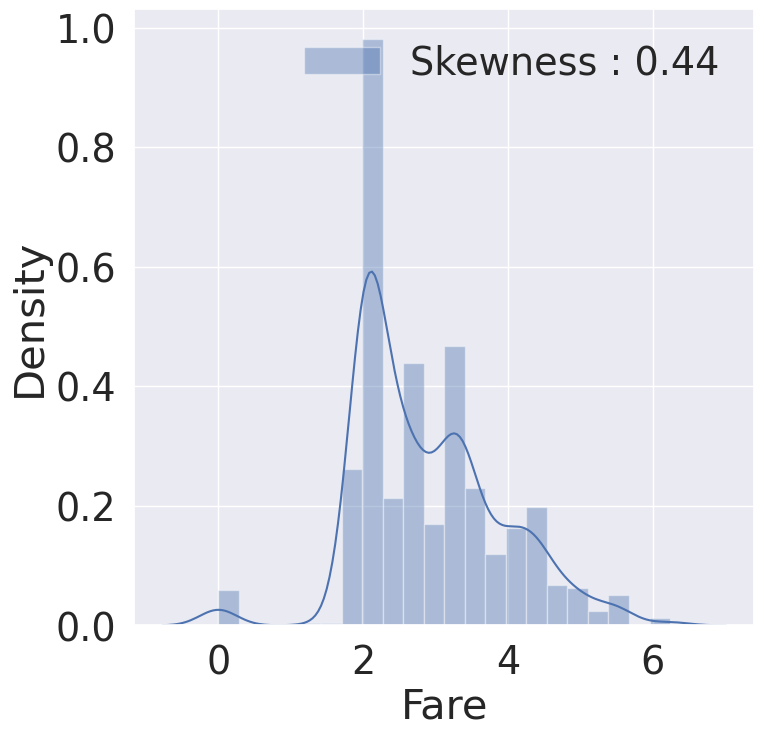

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
g = sns.distplot(df_train['Fare'], color='b', label='Skewness : {:.2f}'.format(df_train['Fare'].skew()), ax=ax)
g = g.legend(loc='best')

* log 를 취하니, 이제 비대칭성이 많이 사라진 것을 볼 수 있습니다.
* 우리는 이런 작업을 사용해 모델이 좀 더 좋은 성능을 내도록 할 수 있습니다.
* 사실 방금한 것은 feature engineering 에 들어가는 부분인데, 여기서 작업했습니다.
* 모델을 학습시키기 위해, 그리고 그 모델의 성능을 높이기 위해 feature 들에 여러 조작을 가하거나, 새로운 feature를 추가하는 것을 feature engineering 이라고 하는데, 우리는 이제 그것을 살펴볼 것입니다.

# 2.9 Cabin

* 이 feature는 NaN 이 대략 80% 이므로, 생존에 영향을 미칠 중요한 정보를 얻어내기가 쉽지는 않습ㄴ다.
* 그러므로 우리가 세우려는 모델에 포함시키지 않도록 하겠습니다.

In [38]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,1.981001,NaN,S,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,4.266662,C85,C,2
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,2.070022,NaN,S,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,3.972177,C123,S,2
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,2.085672,NaN,S,1


# 2.10 Ticket

* 이 feature는 NaN 은 없습니다. 일단 string data 이므로 우리가 어떤 작업들을 해주어야 실제 모델에 사용할 수 있는데, 이를 위해선 사실 아이디어가 필요합니다.

In [39]:
df_train[df_train['Ticket'] == 'PC 17612']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize
295,296,0,1,"Lewy, Mr. Ervin G",male,NaN,0,0,PC 17612,3.322183,NaN,C,1


* 티켓 이름이 같으면 가족.

In [40]:
df_train['Ticket'].value_counts()

347082      7
CA. 2343    7
1601        7
3101295     6
CA 2144     6
           ..
9234        1
19988       1
2693        1
PC 17612    1
370376      1
Name: Ticket, Length: 681, dtype: int64

* 보시다시피, ticket number 는 매우 다양합니다. 우리는 여기서 어떤 특징을 이끌어내서 생존과 연결시킬 수 있을까요?
* 여러분이 직접 한번 아이디어를 내보세요! 이것이 본격적인 캐글 레이스의 시작점입니다 ^^
* 이 튜토리얼에서는 튜토리얼이니 일단 ticket 은 넘기도록 하겠습니다. 튜토리얼을 끝낸 후, 여러분의 모델의 성능을 향상시키기 위해 ticket 에서 정보를 이끌어내는 것도 좋겠네요!
* 본 튜토리얼은 [1](https://www.kaggle.com/arthurtok/introduction-to-ensembling-stacking-in-python), [2](https://www.kaggle.com/startupsci/titanic-data-science-solutions), [3](https://www.kaggle.com/ash316/eda-to-prediction-dietanic), [4](https://www.kaggle.com/yassineghouzam/titanic-top-4-with-ensemble-modeling) 을 참고하여 만들었습니다. 공유해준 캐글러께 감사드립니다.

In [41]:
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

# 3. Feature engineering

* 본격적인 feature engineering 을 시작해보겠습니다.
* 가장 먼저, dataset 에 존재하는 null data를 채우려고 합니다.
* 아무 숫자로 채울 수는 없고, null data 를 포함하는 feature 의 statstics 를 참고하거나, 다른 아이디어를 짜내어 채울 수 있습니다.
* null data 를 어떻게 채우느냐에 따라 모델의 성능이 좌지우지될 수 있기 때문에, 신경써줘야할 부분입니다.
* Feature engineering 은 실제 모델의 학습에 쓰려고 하는 것이므로, train 뿐만아니라 test 도 똑같이 적용해주어야 합니다. 잊지맙시다.

## 3.1 Fill Null

### 3.1.1 Fill Null in Age using title

* Age 에는 null data가 177개나 있습니다. 이를 채울 수 있는 여러 아이디어가 있을 것인데, 여기서 우리는 title + statistics 를 사용해 보겠습니다.
* 영어에서는 Miss, Mrr, Mrs 같은 title이 존재합니다. 각 탑승객의 이름에는 꼭 이런 title 이 들어가게 되는데 이를 사용해보겠습니다.
* pandas series 에는 data 를 string 으로 바꿔주는 str method, 거기에 정규표현식을 적용하게 해주는 extract method가 있습니다. 이를 사용하여 title 을 쉽게 추출할 수 있습니다. title을 initial column 에 저장하겠습니다.

In [42]:
df_train['Initial'] = df_train.Name.str.extract('([A-Za-z]+)\.')
# lets extract the Salutations

df_test['Initial'] = df_test.Name.str.extract('([A-Za-z]+)\.')
# Lets extract the Salutations

* pandas 의 crosstab 을 이용하여 우리가 추출한 Initial 과 Sex 간의 count 를 살펴봅시다.

In [43]:
pd.crosstab(df_train['Initial'], df_train['Sex']).T.style.background_gradient(cmap='summer_r')
# Checking the Initials with the Sex

Initial,Capt,Col,Countess,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir
Sex,,,,,,,,,,,,,,,,,
female,0,0,1,0,1,0,1,0,0,182,2,1,0,125,1,0,0
male,1,2,0,1,6,1,0,2,40,0,0,0,517,0,0,6,1


* 위 table 을 참고하여, 남자, 여자가 쓰는 initial 을 구분해 보겠습니다. replace 메소드를 사용하면, 특정 데이터 값을 원하는 값으로 치환해줍니다.

In [44]:
df_train['Initial'].replace(['Mlle', 'Mme', 'Ms', 'Dr', 'Major', 'Lady', 'Countess', 'Jonkheer', 'Col', 'Rev', 'Capt', 'Sir', 'Don', 'Dona'],
                           ['Miss', 'Miss', 'Miss', 'Mr', 'Mr', 'Mrs', 'Mrs', 'Other', 'Other', 'Other', 'Mr', 'Mr', 'Mr', 'Mr'], inplace=True)
df_test['Initial'].replace(['Mlle', 'Mme', 'Ms', 'Dr', 'Major', 'Lady', 'Countess', 'Jonkheer', 'Col', 'Rev', 'Capt', 'Sir', 'Don', 'Dona'],
                          ['Miss', 'Miss', 'Miss', 'Mr', 'Mr', 'Mrs', 'Mrs', 'Other', 'Other', 'Other', 'Mr', 'Mr', 'Mr', 'Mr'], inplace=True)

In [45]:
df_train.groupby('Initial').mean()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,FamilySize
Initial,,,,,,,,
Master,414.975000,0.575000,2.625000,4.574167,2.300000,1.375000,3.340710,4.675000
Miss,411.741935,0.704301,2.284946,21.860000,0.698925,0.537634,3.123713,2.236559
Mr,455.880907,0.162571,2.381853,32.739609,0.293006,0.151229,2.651507,1.444234
Mrs,456.393701,0.795276,1.984252,35.981818,0.692913,0.818898,3.443751,2.511811
Other,564.444444,0.111111,1.666667,45.888889,0.111111,0.111111,2.641605,1.222222


* 여성과 관계있는 Miss, Mr, Mrs 가 생존률이 높은 것을 볼 수 있습니다.

<AxesSubplot:xlabel='Initial'>

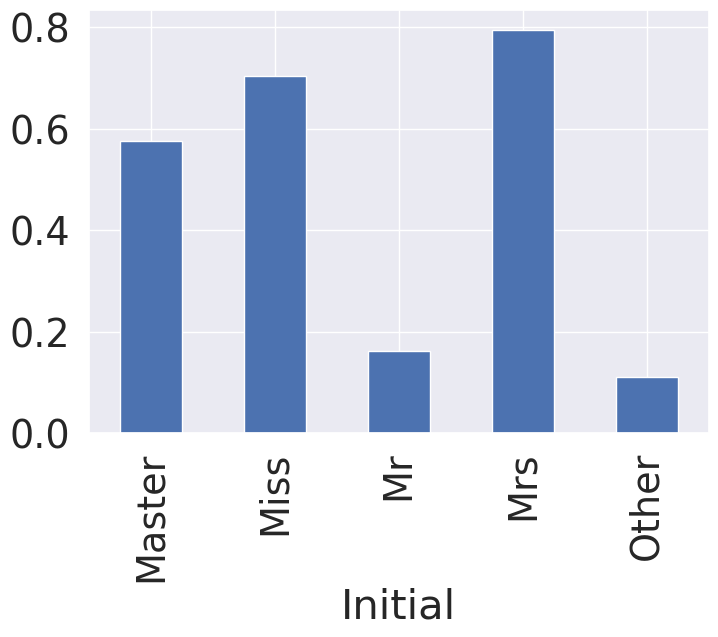

In [46]:
df_train.groupby('Initial')['Survived'].mean().plot.bar()

* 이제 본격적으로 Null 을 채울 것입니다. null data 를 채우는 방법은 정말 많이 존재합니다. statistics 를 활용하는 방법도 있고, null data 가 없는 데이터를 기반으로 새로운 머신러닝 알고리즘을 만들어 예측해서 채워넣는 방식도 있습니다. 여기서는 statistics 를 활용하는 방법을 사용할 것입니다.
* 여기서 statistics 는 train data 의 것을 의미합니다. 우리는 언제나 test 를 unseen 으로 둔 상태로 놔둬야 하며, train 에서 얻은 statistics 를 기반으로 test 의 null data 를 채워줘야 합니다.

In [47]:
df_train.groupby('Initial').mean()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,FamilySize
Initial,,,,,,,,
Master,414.975000,0.575000,2.625000,4.574167,2.300000,1.375000,3.340710,4.675000
Miss,411.741935,0.704301,2.284946,21.860000,0.698925,0.537634,3.123713,2.236559
Mr,455.880907,0.162571,2.381853,32.739609,0.293006,0.151229,2.651507,1.444234
Mrs,456.393701,0.795276,1.984252,35.981818,0.692913,0.818898,3.443751,2.511811
Other,564.444444,0.111111,1.666667,45.888889,0.111111,0.111111,2.641605,1.222222


* Age의 평균을 이용해 Null value를 채우도록 하겠습니다.
* pandas dataframe 을 다룰 때에는 boolean array를 이용해 indexing 하는 방법이 참으로 편리합니다.
* 아래 코드 첫줄을 해석하자면, isnull() 이면서 Initial 이 Mr 인 조건을 만족하는 row(탑승객) 의 'Age' 의 값을 33으로 치환한다 입니다.
* loc + boolean + column 을 사용해 값을 치환하는 방법은 자주 쓰이므로 꼭 익숙해집시다.

In [48]:
df_train.loc[(df_train.Age.isnull()) & (df_train.Initial=='Mr'), 'Age'] = 33
df_train.loc[(df_train.Age.isnull()) & (df_train.Initial=='Mrs'), 'Age'] = 36
df_train.loc[(df_train.Age.isnull()) & (df_train.Initial=='Master'), 'Age'] = 5
df_train.loc[(df_train.Age.isnull()) & (df_train.Initial=='Miss'), 'Age'] = 22
df_train.loc[(df_train.Age.isnull()) & (df_train.Initial=='Other'), 'Age'] = 46

df_test.loc[(df_test.Age.isnull()) & (df_test.Initial=='Mr'), 'Age'] = 33
df_test.loc[(df_test.Age.isnull()) & (df_test.Initial=='Mrs'), 'Age'] = 36
df_test.loc[(df_test.Age.isnull()) & (df_test.Initial=='Master'), 'Age'] = 5
df_test.loc[(df_test.Age.isnull()) & (df_test.Initial=='Miss'), 'Age'] = 22
df_test.loc[(df_test.Age.isnull()) & (df_test.Initial=='Other'), 'Age'] = 46

* 여기선 간단하게 Null을 채웠지만, 좀 더 다양한 방법을 쓴 예시들이 다른 커널에 존재합니다
* https://www.kaggle.com/yassineghouzam/titanic-top-4-with-ensemble-modeling 보시면서 공부해보세요!
* 이 외에도 다른 캐글러들의 커널을 보며 여러 참신한 아이디어를 살펴보세요!

### 3.1.2 Fill Null in Embarked

In [49]:
print('Embarked has ', sum(df_train['Embarked'].isnull()), ' Null values')

Embarked has  2  Null values


* Embarked 는 Null value 가 2개이고, S 에서 가장 많은 탑승객이 있었으므로, 간단하게 Null 을 S로 채우겠습니다.
* dataframe 의 fillna method 를 이용하면 쉽게 채울 수 있습니다. 여기서 inplace=True 로 하면 df_train 에 fillna 를 실제로 적용하게 됩니다.

In [50]:
df_train['Embarked'].fillna('S', inplace=True)

## 3.2 Change Age(continuous to categorical)

* Age 는 현재 continuous feature 입니다. 이대로 서도 모델을 세울 수 있지만, Age 를 몇개의 group 으로 나누어 category 화 시켜줄 수 도 있습니다. continuous 를 categorical 로 바꾸면 자칫 information loss 가 생길 수도 있습니다만, 본 튜토리얼에서는 다양한 방법을 소개하는 것이 목적이므로 진행하도록 하겠습니다.
* 방법은 여러가지가 있습니다. dataframe 의 indexing 방법인 loc 를 사용하여 직접해줄 수 있고, 아니면 apply 를 사용해 함수를 넣어줄 수 있습니다.
* 첫번째로 loc 를 사용한 방법입니다. loc 는 자주쓰게 되므로 그 사용법을 숙지하시면 좋습니다.
* 나이는 10살 간격으로 나누겠습니다.

In [51]:
df_train['Age_cat'] = 0
df_train.loc[df_train['Age'] < 10, 'Age_cat'] = 0
df_train.loc[(10 <= df_train['Age']) & (df_train['Age'] < 20), 'Age_cat'] = 1
df_train.loc[(20 <= df_train['Age']) & (df_train['Age'] < 30), 'Age_cat'] = 2
df_train.loc[(30 <= df_train['Age']) & (df_train['Age'] < 40), 'Age_cat'] = 3
df_train.loc[(40 <= df_train['Age']) & (df_train['Age'] < 50), 'Age_cat'] = 4
df_train.loc[(50 <= df_train['Age']) & (df_train['Age'] < 60), 'Age_cat'] = 5
df_train.loc[(60 <= df_train['Age']) & (df_train['Age'] < 70), 'Age_cat'] = 6
df_train.loc[70 <= df_train['Age'], 'Age_cat'] = 7

df_test['Age_cat'] = 0
df_test.loc[df_test['Age'] < 10, 'Age_cat'] = 0
df_test.loc[(10 <= df_test['Age']) & (df_test['Age'] < 20), 'Age_cat'] = 1
df_test.loc[(20 <= df_test['Age']) & (df_test['Age'] < 30), 'Age_cat'] = 2
df_test.loc[(30 <= df_test['Age']) & (df_test['Age'] < 40), 'Age_cat'] = 3
df_test.loc[(40 <= df_test['Age']) & (df_test['Age'] < 50), 'Age_cat'] = 4
df_test.loc[(50 <= df_test['Age']) & (df_test['Age'] < 60), 'Age_cat'] = 5
df_test.loc[(60 <= df_test['Age']) & (df_test['Age'] < 70), 'Age_cat'] = 6
df_test.loc[70 <= df_test['Age'], 'Age_cat'] = 7

* 두번째로 간단한 함수를 만들어 apply 메소드에 넣어주는 방법입니다.
* 훨씬 수월합니다.

In [52]:
def category_age(x):
    if x < 10:
        return 0
    elif x < 20:
        return 1
    elif x < 30:
        return 2
    elif x < 40:
        return 3
    elif x < 50:
        return 4
    elif x < 60:
        return 5
    elif x < 70:
        return 6
    else:
        return 7

df_train['Age_cat_2'] = df_train['Age'].apply(category_age)

* 두가지 방법이 잘 적용됬다면, 둘다 같은 결과를 내야합니다.
* 이를 확인하기 위해 Series 간 boolean 비교 후 all() 메소드를 사용합시다. all() 메소드는 모든 값이 True 면 True, 하나라도 False 가 있으면 False 를 줍니다.

In [53]:
print('1번 방법, 2번 방법 둘다 같은 결과를 내면 True 줘야함 -> ', (df_train['Age_cat'] == df_train['Age_cat_2']).all())

1번 방법, 2번 방법 둘다 같은 결과를 내면 True 줘야함 ->  True


* 보시다시피 True 입니다. 둘 중 편한 걸 선택하시면 됩니다.
* 이제 중복되는 Age_cat 컬럼과 원래 컬럼 Age 를 제거하겠습니다.

In [54]:
df_train.drop(['Age', 'Age_cat_2'], axis=1, inplace=True)
df_test.drop(['Age'], axis=1, inplace=True)

## 3.3 Change Initial, Embarked and Sex (string to numerical)

* 현재 Initial 은 Mr, Mrs, Miss, Master, Other 총 5개로 이루어져 있습니다. 이런 카테고리로 표현되어져 있는 데이터를 모델에 인풋으로 넣어줄 때 우리가 해야할 것은 먼저 컴퓨터가 인식할 수 있도록 수치화 시켜야 합니다.
* map method 를 가지고 간단히 할 수 있습니다.
* 사전 순서대로 정리하여 mapping 하겠습니다.

In [55]:
df_train['Initial'] = df_train['Initial'].map({'Master': 0, 'Miss': 1, 'Mr': 2, 'Mrs': 3, 'Other': 4})
df_test['Initial'] = df_test['Initial'].map({'Master': 0, 'Miss': 1, 'Mr': 2, 'Mrs': 3, 'Other': 4})

* Embarked 도 C, Q, S로 이루어져 있습니다. map 을 이용해 바꿔봅시다.
* 그러기 앞서서, 특정 column 에 어떤 값들이 있는 지 확인해보는 방법을 잠깐 살펴보겠습니다. 간단히 unique() 메소드를 쓰거나, value_counts() 를 써서 count 까지 보는 방법이 있습니다.

In [56]:
df_train['Embarked'].unique()

array(['S', 'C', 'Q'], dtype=object)

In [57]:
df_train['Embarked'].value_counts()

S    646
C    168
Q     77
Name: Embarked, dtype: int64

In [58]:
df_train['Embarked'] = df_train['Embarked'].map({'C': 0, 'Q': 1, 'S': 2})
df_test['Embarked'] = df_test['Embarked'].map({'C': 0, 'Q': 1, 'S': 2})

* 한번 Null 이 사라졌는지 확인해봅시다. Embarked Column만 가져온 것은 하나의 pandas 의 Series 객체므로, isnull() 메소드를 사용해 Series의 값들이 null 인지 아닌지에 대한 boolean 값을 얻을 수 있습니다. 그리고 이것에 any() 를 사용하여, True 가 단하나라도 있을 시(Null이 한개라도 있을 시) True 를 반환해주게 됩니다. 우리는 Null 을 S로 다 바꿔주었으므로 False 를 얻게 됩니다.

In [59]:
df_train['Embarked'].isnull().any()

False

In [60]:
df_train['Sex'] = df_train['Sex'].map({'female': 0, 'male': 1})
df_test['Sex'] = df_test['Sex'].map({'female': 0, 'male': 1})

* 여지껏 고생하셨습니다. 이제 각 feature 간의 상관관계를 한번 보려고 합니다. 두 변수간의 Pearson correlation 을 구하면 (-1, 1) 사이의 값을 얻을 수 있습니다. -1로 갈수록 음의 상관관계, 1로 갈수록 양의 상관관계를 의미하며, 0은 상관관계가 없다는 것을 의미합니다. 구하는 수식은 아래와 같습니다.  

rxy=Cov(x,y) / SxSy = 1/n−1∑ni=1(xi−x¯)(yi−y¯) / SxSy

* 우리는 여러 feature 를 가지고 있으니 이를 하나의 maxtrix 형태로보면 편할 텐데, 이를 heatmap plot 이라고 하며, dataframe 의 corr() 메소드와 seaborn 을 가지고 편하게 그릴 수 있습니다.

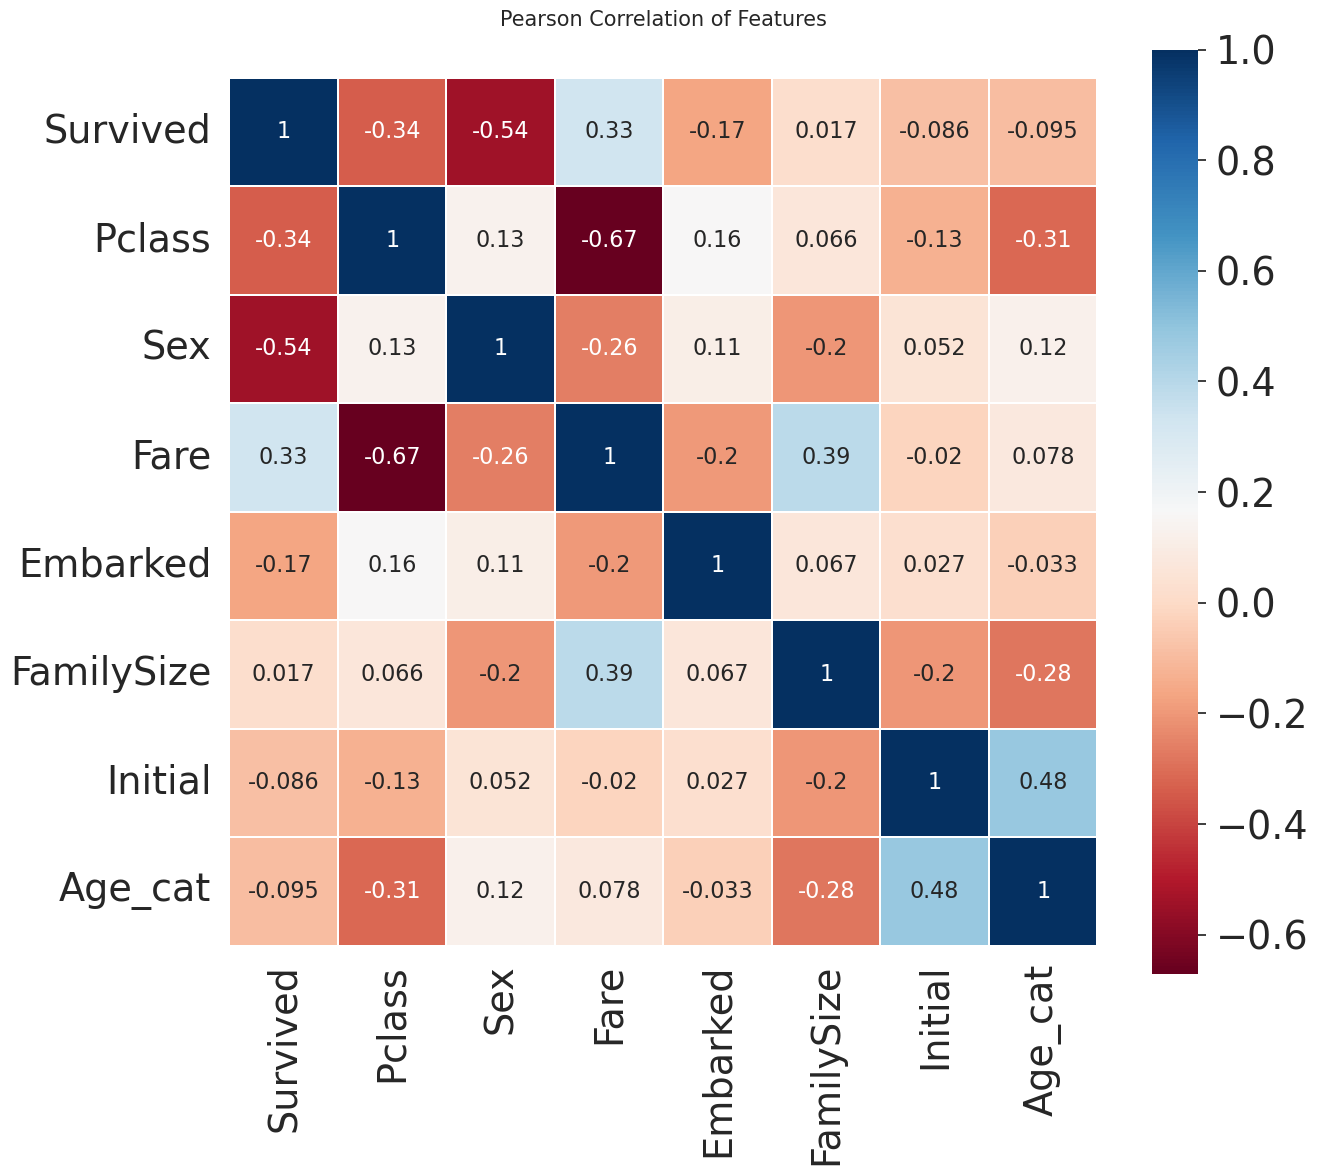

In [61]:
heatmap_data = df_train[['Survived', 'Pclass', 'Sex', 'Fare', 'Embarked', 'FamilySize', 'Initial', 'Age_cat']]

colormap = plt.cm.RdBu
plt.figure(figsize=(14, 12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(heatmap_data.astype(float).corr(), linewidth=0.1, vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True, annot_kws={'size': 16})

del heatmap_data

* 우리가 EDA에서 살펴봤듯이, Sex 와 Pclass 가 Survived 에 상관관계가 어느 정도 있을을 볼 수 있습니다.
* 생각보다 fare 와 Embarked 도 상관관계가 있음을 볼 수 있습니다.
* 또한 우리가 여기서 얻을 수 있는 정보는 서로 강한 상관관계를 가지는 feature들이 없다는 것입니다.
* 이것은 우리가 모델을 학습시킬 때, 불필요한(redundant, superfluous) feature 가 없다는 것을 의미합니다. 1 또는 -1 의 상관관계를 가진 feature A, B 가 있다면, 우리가 얻을 수 있는 정보는 사실 하나일 거니까요.
* 이제 실제로 모델을 학습시키기 앞서서 data preprocessing (전처리) 을 진행해보겠습니다. 거의 다 와값니다 힘냅시다!

## 3.4 One-hot encoding on Initial and Embarked

* 수치화시킨 카테고리 데이터를 그대로 넣어도 되지만, 모델의 성능을 높이기 위해 one-hot encoding을 해줄 수 있습니다.
* 수치화는 간단히 Master == 0, Miss == , Mr == 2, Mrs == 3, Other == 4 로 매핑해주는 것을 말합니다.
* One-hot encoding 은 위 카테고리를 아래와 같이 (0, 1) 로 이루어진 5차원의 벡터로 나타내는 것을 말합니다.

* 위와 같은 작업을 직접 코딩할 수도 있지만, pandas 의 get_dummies 를 사용하여 쉽게 해결 할 수 있습니다.
* 총 5개의 카테고리니, one-hot encoding 을 하고 나면 새로운 5개의 column 이 생겨납니다.
* Initial 을 prefix로 두어서 구분이 쉽게 만들어 줍니다.

In [62]:
df_train = pd.get_dummies(df_train, columns=['Initial'], prefix='Initial')
df_test = pd.get_dummies(df_test, columns=['Initial'], prefix='Initial')

In [63]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,Age_cat,Initial_0,Initial_1,Initial_2,Initial_3,Initial_4
0,1,0,3,"Braund, Mr. Owen Harris",1,1,0,A/5 21171,1.981001,NaN,2,2,2,0,0,1,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,0,PC 17599,4.266662,C85,0,2,3,0,0,0,1,0
2,3,1,3,"Heikkinen, Miss. Laina",0,0,0,STON/O2. 3101282,2.070022,NaN,2,1,2,0,1,0,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,1,0,113803,3.972177,C123,2,2,3,0,0,0,1,0
4,5,0,3,"Allen, Mr. William Henry",1,0,0,373450,2.085672,NaN,2,1,3,0,0,1,0,0


* 보시다시피 오른쪽에 우리가 만들려고 했던 one-hot encoded columns 가 생성된 것이 보입니다.
* Embarked 에도 적용하겠습니다. Initial 때와 마찬가지로 one-hot encoding 을 사용해 표현하겠습니다.

In [64]:
df_train = pd.get_dummies(df_train, columns=['Embarked'], prefix='Embarked')
df_test = pd.get_dummies(df_test, columns=['Embarked'], prefix='Embarked')

* 아주 쉽게 one-hot encoding 을 적용했습니다.
* sklearn 로 Labelencoder + OneHotencoder 이용해도 one-hot encoding 이 가능합니다.
* 다른 튜토리얼에서 한번 써보겠습니다. 여기서는 get_dummies 로 충분히 가능하기 때문에 get_dummies 만으로 끝내겠습니다.
* 가끔 category 가 100개가 넘어가는 경우가 있습니다. 이때 one-hot encoding을 사용하면 column이 100개가 생겨, 학습시 매우 버거울 경우가 있습니다. 이런 경우는 다른 방법을 사용하기도 하는데, 이는 다음에 한번 다뤄보겠습니다.

## 3.5 Drop columns

* 고생하셨습니다. 이제 책상을 치울 때 입니다. 필요한 columns 만 남기고 다 지웁시다.

In [65]:
df_train.drop(['PassengerId', 'Name', 'SibSp', 'Parch', 'Ticket', 'Cabin'], axis=1, inplace=True)
df_test.drop(['PassengerId', 'Name', 'SibSp', 'Parch', 'Ticket', 'Cabin'], axis=1, inplace=True)

In [66]:
df_train.head()

,Survived,Pclass,Sex,Fare,FamilySize,Age_cat,Initial_0,Initial_1,Initial_2,Initial_3,Initial_4,Embarked_0,Embarked_1,Embarked_2
0,0,3,1,1.981001,2,2,0,0,1,0,0,0,0,1
1,1,1,0,4.266662,2,3,0,0,0,1,0,1,0,0
2,1,3,0,2.070022,1,2,0,1,0,0,0,0,0,1
3,1,1,0,3.972177,2,3,0,0,0,1,0,0,0,1
4,0,3,1,2.085672,1,3,0,0,1,0,0,0,0,1


In [67]:
df_test.head()

,Pclass,Sex,Fare,FamilySize,Age_cat,Initial_0,Initial_1,Initial_2,Initial_3,Initial_4,Embarked_0,Embarked_1,Embarked_2
0,3,1,2.057860,1,3,0,0,1,0,0,0,1,0
1,3,0,1.945910,2,4,0,0,0,1,0,0,0,1
2,2,1,2.270836,1,6,0,0,1,0,0,0,1,0
3,3,1,2.159003,1,2,0,0,1,0,0,0,0,1
4,3,0,2.508582,3,2,0,0,0,1,0,0,0,1


* 보시다시피, train 의 Survived feature(target class)를 빼면 train, test 둘다 같은 columns 를 가진 걸 확인할 수 있습니다.

# 4. Building machine learining model and prediction using the trained model

* 이제 준비가 다 되었으니 sklearn 을 사용해 본격적으로 머신러닝 모델을 만들어 봅시다.

In [68]:
# importing all the required ML packages
from sklearn.ensemble import RandomForestClassifier
# 유명한 randomforestclassfier 입니다.
from sklearn import metrics # 모델의 평가를 위해서 씁니다.
from sklearn.model_selection import train_test_split
# training set 을 쉽게 나눠주는 함수입니다.

* Sklearn 은 머신러닝의 처음부터 끝까지가 다 있습니다. feature engineering, preprocessing, 지도 학습 알고리즘, 비지도 학습 알고리즘, 모델 평가, 파이프라인 등 머신러닝에 관련된 모든 작업들이 손쉬운 인터페이스로 구현되어 있습니다. 데이터 분석 + 머신러닝을 하고싶다면, 이 라이브러리는 반드시 숙지해야합니다.
* 파이썬 라이브러리를 활용한 머신러닝(Introduction to machine learning with Python) 책을 사서 공부하시길 매우 추천드립니다.

* 지금 타이타닉 문제는 target class(survived)가 있으며, target class 는 0, 1로 이루어져 있으므로(binary) binary classfication 문제입니다.
* 우리가 지금 가지고 train set 의 survived를 제외한 input 을 가지고 모델을 최적화시켜서 각 샘플(탑승객)의 생존유무를 판단하는 모델을 만들어 냅니다.
* 그 후 모델이 학습하지 않았던 test set 을 input 으로 주어서 test set 이 각 샘플(탑승객)의 생존 유무를 예측해봅니다.

## 4.1 Preparation - Split dataset into train, valid, test set

* 가장 먼저, 학습에 쓰일 데이터와, target label(Survived)를 분리합니다. drop 을 사용해 간단히 할 수 있습니다.

In [69]:
X_train = df_train.drop('Survived', axis=1).values
target_label = df_train['Survived'].values
X_test = df_test.values

* 보통 train, test 만 언급되지만, 실제 좋은 모델을 만들기 위해서 우리는 valid set 을 따로 만들어 모델 평가를 해봅니다.
* 마치 축구대표팀이 팀훈련(train)을 하고 바로 월드컵(test)로 나가는 것이 아니라, 팀훈련(train)을 한 다음 평가전(valid)를 거쳐 팀의 훈련 정도(학습정도)를 확인하고 월드컵(test)에 나가는 것과 비슷합니다.
* train_test_split 을 사용하여 쉽게 train 셋을 분리할 수 있습니다.

In [70]:
X_tr, X_vld, y_tr, y_vld = train_test_split(X_train, target_label, test_size=0.3, random_state=2018)

* sklearn 에서는 여러 머신러닝 알고리즘을 지원해줍니다. 열거하기엔 너무 많으므로, 직접 documentation에 들어가 보시길 추천합니다. http://scikit-learn.org/stable/supervised_learning.html#supervised-learning 여기에 들어가시면 지원되는 알고리즘 수에 놀라실 겁니다.
* 본 튜토리얼에서는 랜덤포레스트 모델을 사용하도록 하겠습니다.
* 랜던포레스트는 결정트리기반 모델이며, 여러 결정 트리들을 앙상블한 모델립니다. 더 구체적으로 모델 설명은 여러 블로그들 참고하시면 될것이고, 저도 한번 추후 다뤄보겠습니다.
* 각 머신러닝 알고리즘에는 여러 파라미터들이 있습니다. 랜덤포레스트 분류기도 nestimators, max_features, max_depth, min_samples_split, min_samples_leaf 등 여러 파라미터들이 존재합니다. 이것들이 어떻게 세팅되냐에 따라 같은 데이터셋이라 하더라도 모델의 성능이 달라집니다.
* 파라미터 튜닝은 시간, 경험, 알고리즘에 대한 이해 등이 필요합니다. 결국 많이 써봐야 모델도 잘 세울 수 있는 것이죠. 그래서 캐글을 추천합니다. 여러 데이터셋을 가지고 모델을 이리저리 써봐야 튜닝하는 감이 생길테니까요!
* 일단 지금은 튜토리얼이니 파라미너 튜닝은 잠시 제쳐두기로 하고, 기본 default 세팅으로 진행하겠습니다.
* 모델 객체를 만들고, fit 메소드로 학습시킵니다.
* 그런 후 valid set input 을 넣어주어 예측값(X_vld sample(탑승객)의 생존여부)를 얻습니다.

## 4.2 Model generation and prediction

In [71]:
model = RandomForestClassifier()
model.fit(X_tr, y_tr)
prediction = model.predict(X_vld)

* 단 세줄만으로 여러분은 모델을 세우고, 예측까지 해봤습니다.
* 자, 이제 모델의 성능을 한번 살펴보겠습니다.

In [72]:
print('총 {}명 중 {:.2f}% 정확도로 생존을 맞춤'.format(y_vld.shape[0], 100 * metrics.accuracy_score(prediction, y_vld)))

총 268명 중 81.34% 정확도로 생존을 맞춤


* 아무런 파라미터 튜닝도 하지 않았는데 82% 의 정확도가 나왔습니다. 고생하셨습니다!

## 4.3 Feature importance

* 학습된 모델은 feature importance 를 가지게 되는데, 우리는 이것을 확인하여 지금 만든 모델이 어떤 feature 에 영향을 많이 받았는 지 확인할 수 있습니다.
* 쉽게 말해, 10 = 4x1 + 2x2 + 1*x3 을 생각하면, 우리는 x1이 결과값(10)에 큰 영향을 준다고 생각 할 수 있습니다. feature importance 는 4, 2, 1 을 이야기하며, x1이 가장 큰 값(4)를 가지므로, 이 모델에 가장 큰 영향을 미친다고 말할 수 있습니다.
* 학습된 모델은 기본적으로 feature importance 를 가지고 있어서 쉽게 그 수치를 얻을 수 있습니다.
* pandas series 를 이용하면 쉽게 sorting 을 하여 그래프를 그릴 수 있습니다.

In [73]:
from pandas import Series

feature_importance = model.feature_importances_
Series_feat_imp = Series(feature_importance, index=df_test.columns)

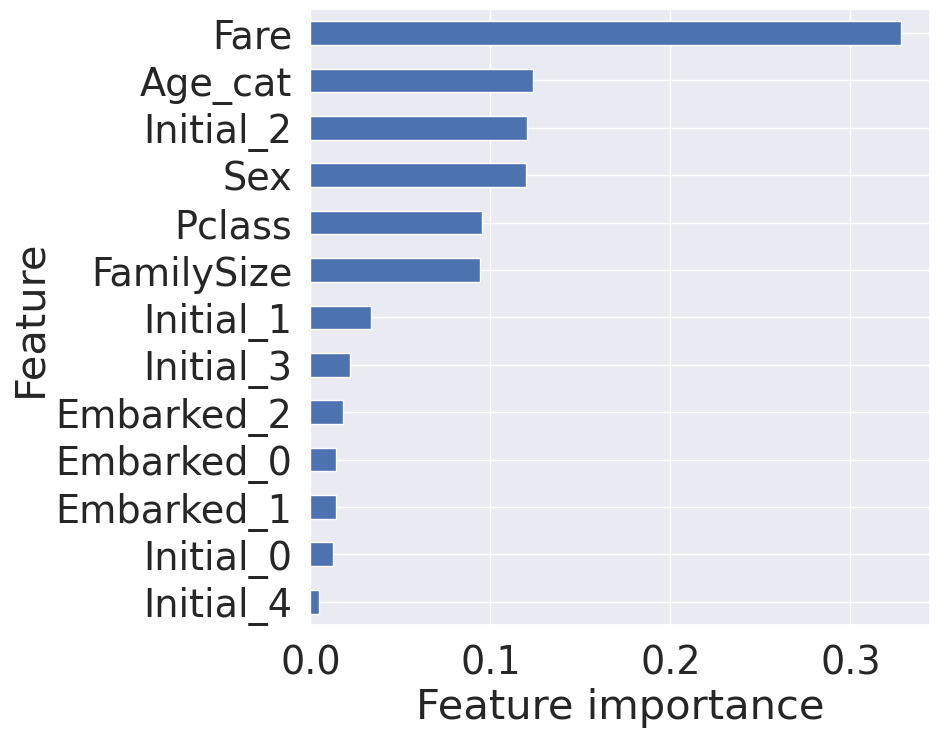

In [74]:
plt.figure(figsize=(8, 8))
Series_feat_imp.sort_values(ascending=True).plot.barh()
plt.xlabel('Feature importance')
plt.ylabel('Feature')
plt.show()

* 우리가 얻은 모델에서는 Fare 가 가장 큰 영향력을 가지며, 그 뒤로 Initial_2, Age_cat, Pclass가 차례로 중요도를 가집니다.
* 사실 feature importance 는 지금 모델에서의 importance 를 나타냅니다. 만약 다른 모델을 사용하게 된다면 feature importance 가 다르게 나올 수 있습니다.
* 이 feature importance 를 보고 실제로 Fare 가 중요한 feature 일 수 있다고 판단을 내릴 수는 있지만, 이것은 결국 모델에 귀속되는 하나의 결론이므로 통계적으로 좀 더 살펴보긴 해야합니다.
* feature importance 를 가지고 좀 더 정확도가 높은 모델을 얻기 위해 feature selection 을 할 수도 있고, 좀 더 빠른 모델을 위해 feature 제거를 할 수 있습니다.

## 4.4 Prediction on Test set

* 이제 모델이 학습하지 않았던(보지 않았던) 테스트셋을 모델에 주어서, 생존여부를 예측해보겠습니다.
* 이 결과는 실제로 submission(제출용) 이므로 결과는 leaderboard 에서 확인할 수 있습니다.
* 캐글에서 준 파일, gender_submission.csv 파일을 읽어서 제출 준비를 하겠습니다.

In [75]:
submission = pd.read_csv('../input/titanic/gender_submission.csv')

In [76]:
submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


* 이제 testset에 대하여 예측을 하고, 결과를 csv 파일로 저장해보겠습니다.

In [77]:
prediction = model.predict(X_test)
submission['Survived'] = prediction

In [78]:
submission.to_csv('./my_first_submission.csv', index=False)

* 이제 캐글에 제출해보도록 합시다.

# 5. Conclusion

* 정말 수고하셨습니다. 여러분은 titanic dataset 을 가지고 data science 를 경험해보셨습니다.
* 이걸로 끝이 아닙니다. 앞으로 배울 것이 너무나 무궁무진합니다.
* 좀 더 참신한 feature engineering, 머신 러닝 모델 hyperparameter tunning, ensembling 등, 무궁무진합니다..
* 꾸준히 커널공부를 하시면 실력이 꾸준히 늘겁니다.
* 포기하지 마시고 재밌게 하시면 됩니다.
* 본 튜토리얼을 따라해주셔서 감사하며, 제 유부트 채널에 강의도 올려놨으니 한번 보시면 됩니다!
* 본 튜토리얼을 따라하시다가, 혹시 문제가 있거나, 궁금한 사항이 있으면 언제든 말씀해주세요! 저도 더 성장하길 원합니다!
* 본 튜토리얼은 [1](https://www.kaggle.com/arthurtok/introduction-to-ensembling-stacking-in-python), [2](https://www.kaggle.com/startupsci/titanic-data-science-solutions), [3](https://www.kaggle.com/ash316/eda-to-prediction-dietanic), [4](https://www.kaggle.com/yassineghouzam/titanic-top-4-with-ensemble-modeling) 을 참고하여 만들었습니다. 공유해주신 캐글러께 감사드립니다.

==============================

1. 
2. 2.3 1번 ?, 2번 차트 분할이 안됨.
3. 2.6 3번 plt.subplots_adjust(wspace=0.2, hspace=0.5)
4. 2.8 1번 차트 곡선이 끝까지 안따라가는 이유?